## Анализ и прогнозирование временных рядов методами искусственного интеллекта

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Практическая работа 3. Поиск аномалий во временных рядах.**


#### **3.1 Поиск диссонансов с помощью алгоритма HotSAX**

##### 3.1.1 Загрузка и подготовка данных

В данной будет использоваться временной ряд, состоящий из показаний акселерометра.
Анализируемый временной ряд, описывает две активности человека - бег и шаг.


In [2]:
!pip install scipy
!pip install scikit-learn

In [3]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from time import time
import pandas as pd

import sys
sys.path.insert(0,'/content/drive/MyDrive/Временные ряды/03 Discords')


In [4]:
#fixme: Путь
dataset_dir_path = Path('/content/drive/MyDrive/Временные ряды/03 Discords/datasets')
data_path = dataset_dir_path/'walk_run.txt'
walk_run = np.loadtxt(data_path)[3000:4000]
data = walk_run
size_sub = 50

В середине временного ряда происходит смена активности (бег заменяет шаг). Нетипичным поведением, которое мы могли бы назвать диссонансами в данном ряде выступает небольшой участок между активностями, когда человек плавно увеличивает скорость шага до бега. В ходе данной работе наша задача выделить с помощью различных алгоритмов границы нашего диссонанса.

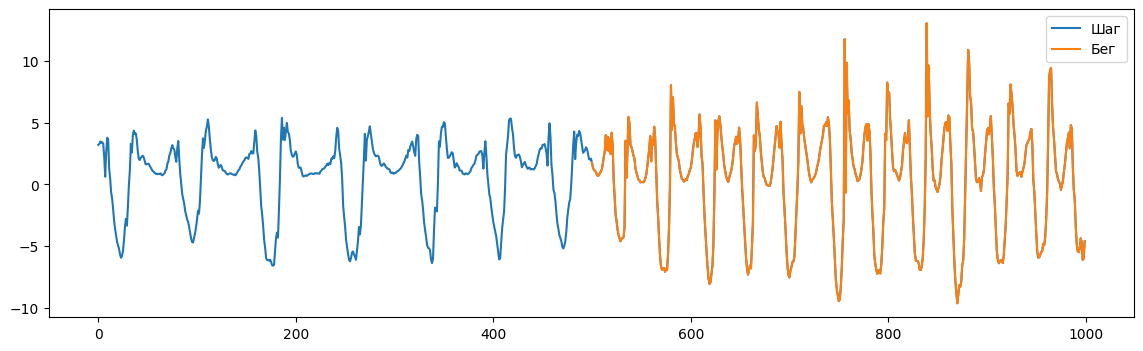

In [ ]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
plt.legend()

In [7]:
result={}
times={}

##### 3.1.2 Реализация полного перебора

Приводится пример кода для нахождения топ 5 диссонансов с помощью реализации полного беребора.
Вам необходимо добавить код для сбора времени обработки данных.

In [ ]:
from modules.saxpy.discord import find_discords_brute_force
start = time()
discords_brute_force= np.stack(find_discords_brute_force(data[:], 50, 5))
end = time()
result['bruteForce'] = discords_brute_force
times['bruteForce'] = end - start

##### 3.1.3 HotSAX

Используя [реализацию](https://github.com/seninp/saxpy/blob/master/saxpy/hotsax.py) найдите топ 5 диссонансов ряда.
Произведите замер времени работы.

In [5]:
!pip install saxpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.9/234.9 kB 11.6 MB/s eta 0:00:00
  Created wheel for saxpy: filename=saxpy-1.0.1.dev167-py3-none-any.whl size=17689 sha256=285dc6cbcba04336954ffc2a47318ac3dd89b02510a7350cabba25919e2cdfbe
  Stored in directory: /root/.cache/pip/wheels/d4/06/c3/f226109b89f615fa451878c3fb8f37110889e575343fc04891
Successfully built saxpy


In [8]:
# INSERT YOUR CODE
"""Implements HOT-SAX."""
import numpy as np
from saxpy.znorm import znorm
from saxpy.sax import sax_via_window
from saxpy.distance import euclidean


def find_discords_hotsax(series, win_size=100, num_discords=2, alphabet_size=3,
                         paa_size=3, znorm_threshold=0.01, sax_type='unidim'):
    """HOT-SAX-driven discords discovery."""
    discords = list()

    global_registry = set()

    # Z-normalized versions for every subsequence.
    znorms = np.array([znorm(series[pos: pos + win_size], znorm_threshold) for pos in range(len(series) - win_size + 1)])

    # SAX words for every subsequence.
    sax_data = sax_via_window(series, win_size=win_size, paa_size=paa_size, alphabet_size=alphabet_size,
                              nr_strategy=None, z_threshold=0.01)

    """[2.0] build the 'magic' array"""
    magic_array = list()
    for k, v in sax_data.items():
        magic_array.append((k, len(v)))

    """[2.1] sort it ascending by the number of occurrences"""
    magic_array = sorted(magic_array, key=lambda tup: tup[1])

    while len(discords) < num_discords:

        best_discord = find_best_discord_hotsax(series, win_size, global_registry, sax_data, magic_array, znorms)

        if -1 == best_discord[0]:
            break

        discords.append(best_discord)

        mark_start = max(0, best_discord[0] - win_size + 1)
        mark_end = best_discord[0] + win_size

        for i in range(mark_start, mark_end):
            global_registry.add(i)

    return discords


def find_best_discord_hotsax(series, win_size, global_registry, sax_data, magic_array, znorms):
    """Find the best discord with hotsax."""

    """[3.0] define the key vars"""
    best_so_far_position = -1
    best_so_far_distance = 0.

    distance_calls = 0

    visit_array = np.zeros(len(series), dtype=int)

    """[4.0] and we are off iterating over the magic array entries"""
    for entry in magic_array:

        """[5.0] current SAX words and the number of other sequences mapping to the same SAX word."""
        curr_word = entry[0]
        occurrences = sax_data[curr_word]

        """[6.0] jumping around by the same word occurrences makes it easier to
        nail down the possibly small distance value -- so we can be efficient
        and all that..."""
        for curr_pos in occurrences:

            if curr_pos in global_registry:
                continue

            """[7.0] we don't want an overlapping subsequence"""
            mark_start = curr_pos - win_size + 1
            mark_end = curr_pos + win_size
            visit_set = set(range(mark_start, mark_end))

            """[8.0] here is our subsequence in question"""
            cur_seq = znorms[curr_pos]

            """[9.0] let's see what is NN distance"""
            nn_dist = np.inf
            do_random_search = True

            """[10.0] ordered by occurrences search first"""
            for next_pos in occurrences:

                """[11.0] skip bad pos"""
                if next_pos in visit_set:
                    continue
                else:
                    visit_set.add(next_pos)

                """[12.0] distance we compute"""

                dist = euclidean(cur_seq, znorms[next_pos])
                distance_calls += 1

                """[13.0] keep the books up-to-date"""
                if dist < nn_dist:
                    nn_dist = dist
                if dist < best_so_far_distance:
                    do_random_search = False
                    break

            """[13.0] if not broken above,
            we shall proceed with random search"""
            if do_random_search:
                """[14.0] build that random visit order array"""
                curr_idx = 0
                for i in range(0, (len(series) - win_size + 1)):
                    if not(i in visit_set):
                        visit_array[curr_idx] = i
                        curr_idx += 1
                it_order = np.random.permutation(visit_array[0:curr_idx])
                curr_idx -= 1

                """[15.0] and go random"""
                while curr_idx >= 0:
                    rand_pos = it_order[curr_idx]
                    curr_idx -= 1

                    dist = euclidean(cur_seq, znorms[rand_pos])
                    distance_calls += 1

                    """[16.0] keep the books up-to-date again"""
                    if dist < nn_dist:
                        nn_dist = dist
                    if dist < best_so_far_distance:
                        nn_dist = dist
                        break

            """[17.0] and BIGGER books"""
            if (nn_dist > best_so_far_distance) and (nn_dist < np.inf):
                best_so_far_distance = nn_dist
                best_so_far_position = curr_pos

    return best_so_far_position, best_so_far_distance


In [ ]:
start = time()
discrods_hot_sax =  np.stack(find_discords_hotsax(data[:], 50, 5))
end = time()

result['hotSax'] = discrods_hot_sax
times['hotSax'] = end - start


##### 3.1.4 Визаулизация

Вам необходимо реализовать код позволяющий:
1. Вывести на одном графике ряд и его диссонансы
2. Столбчатую диаграмму времени работы обоих алгоритмов
   
Постройте графики для обоих алгоритмов и сравните полученные результаты.

Пример графика:

![first_graf](pics/fig_ex_1.png)

In [ ]:
# INSERT YOUR CODE

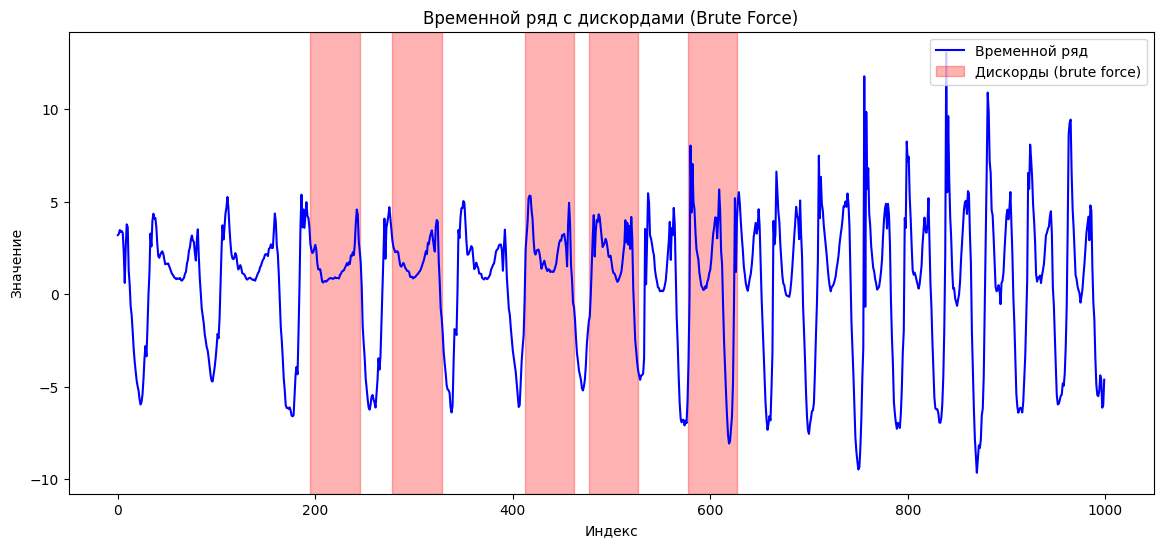

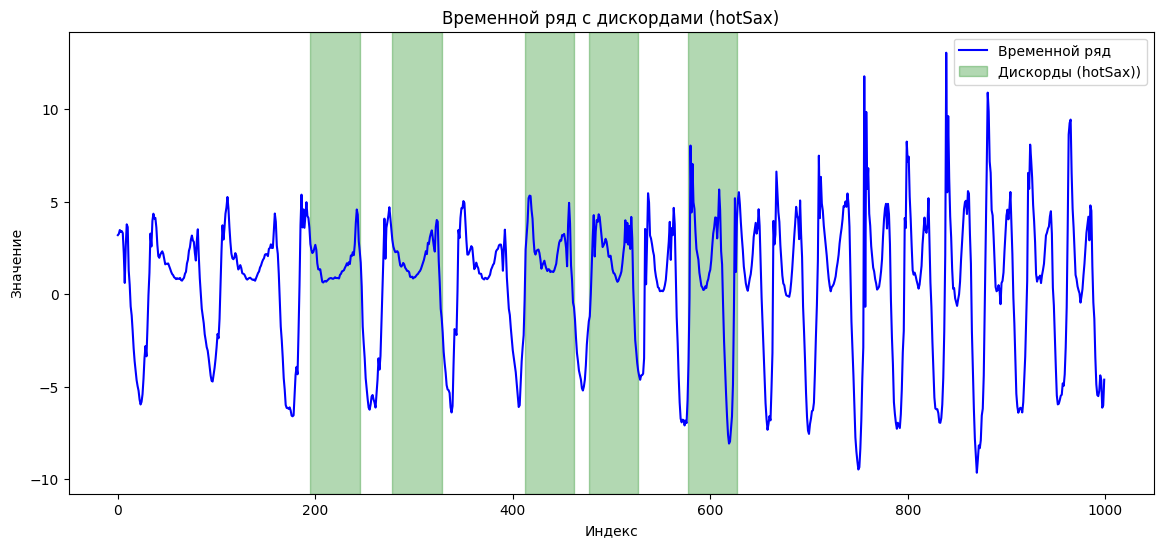

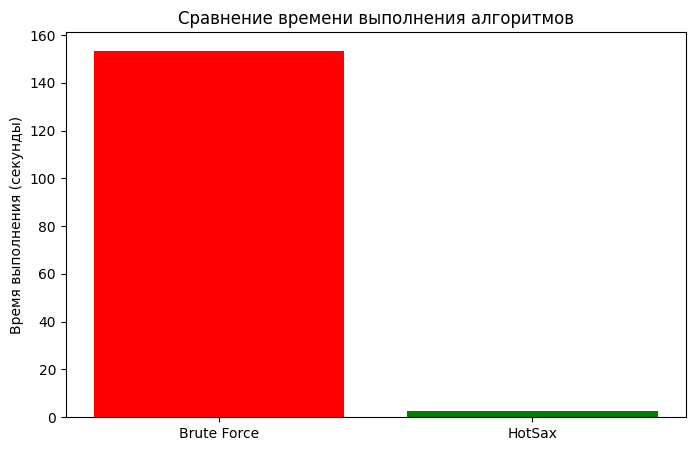

In [ ]:
from matplotlib.patches import Rectangle

win_size = 50
plt.figure(figsize=(14, 6))

# График временного ряда
plt.plot(data, label='Временной ряд', color='blue')

# # Выделение дискордов (brute force)
# for discord in result['bruteForce']:
#     start_idx = int(discord[0])  # Начальный индекс дискорда
#     plt.axvspan(start_idx, start_idx + win_size, color='red', alpha=0.3, label='Дискорды (brute force)')

# # Выделение дискордов (hotSax)
# for discord in result['hotSax']:
#     start_idx = int(discord[0])  # Начальный индекс дискорда
#     plt.axvspan(start_idx, start_idx + win_size, color='green', alpha=0.3, label='Дискорды (оптимизированный)')

# plt.title("Временной ряд с дискордами")
# plt.xlabel("Индекс")
# plt.ylabel("Значение")
# plt.legend(loc='upper right')
# plt.show()

# # 4. Столбчатая диаграмма времени работы
# plt.figure(figsize=(8, 5))
# algorithms = ['Brute Force', 'HotSax']
# times = [times['bruteForce'], times['hotSax']]

# plt.bar(algorithms, times, color=['red', 'green'])
# plt.ylabel("Время выполнения (секунды)")
# plt.title("Сравнение времени выполнения алгоритмов")
# plt.show()

for discord in result['bruteForce']:
    start_idx = int(discord[0])
    plt.axvspan(start_idx, start_idx + win_size, color='red', alpha=0.3, label='Дискорды (brute force)')

# Удаление дубликатов меток
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.title("Временной ряд с дискордами (Brute Force)")
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.show()

# 4. Вторая фигура: Временной ряд с дискордами (hotSax)
plt.figure(figsize=(14, 6))
plt.plot(data, label='Временной ряд', color='blue')

for discord in result['hotSax']:
    start_idx = int(discord[0])
    plt.axvspan(start_idx, start_idx + win_size, color='green', alpha=0.3, label='Дискорды (hotSax))')

# Удаление дубликатов меток
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.title("Временной ряд с дискордами (hotSax)")
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.show()

# 4. Столбчатая диаграмма времени работы
plt.figure(figsize=(8, 5))
algorithms = ['Brute Force', 'HotSax']
times_ = [times['bruteForce'], times['hotSax']]

plt.bar(algorithms, times_, color=['red', 'green'])
plt.ylabel("Время выполнения (секунды)")
plt.title("Сравнение времени выполнения алгоритмов")
plt.show()

##### 3.1.5 Такси NY

Произведите поиск диссонансов с помощью обоих алгоритмов на наборе данных, содержащим информацию о среднем числе пассажиров в NY. Отобразите найденные диссонансы обоими алгоритмами.

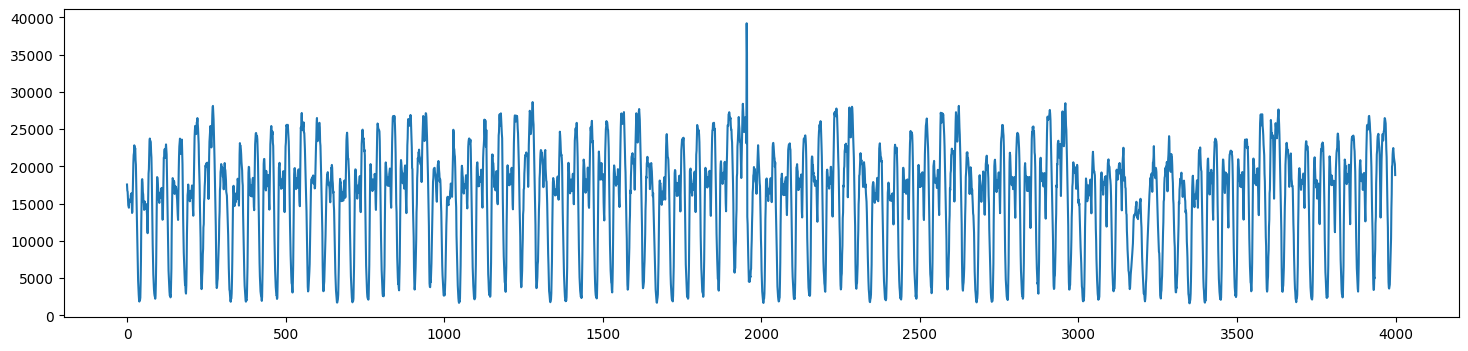

In [13]:
nyc_taxi = pd.read_csv(dataset_dir_path/'nyc_taxi.csv',index_col=0).values[4000:8000,0].astype(np.float64)
fig = plt.figure(figsize=(18, 4))
plt.plot(nyc_taxi)

# INSERT YOUR CODE

In [ ]:
#брут форс

start = time()
discords_brute_force_taxi= np.stack(find_discords_brute_force(nyc_taxi[:], 200, 5))
end = time()
result['bruteForce_taxi'] = discords_brute_force_taxi
times['bruteForce_taxi'] = end - start

#hotSax
start = time()
discrods_hot_sax_taxi =  np.stack(find_discords_hotsax(nyc_taxi[:], 200, 5))
end = time()

result['hotSax_taxi'] = discrods_hot_sax_taxi
times['hotSax_taxi'] = end - start




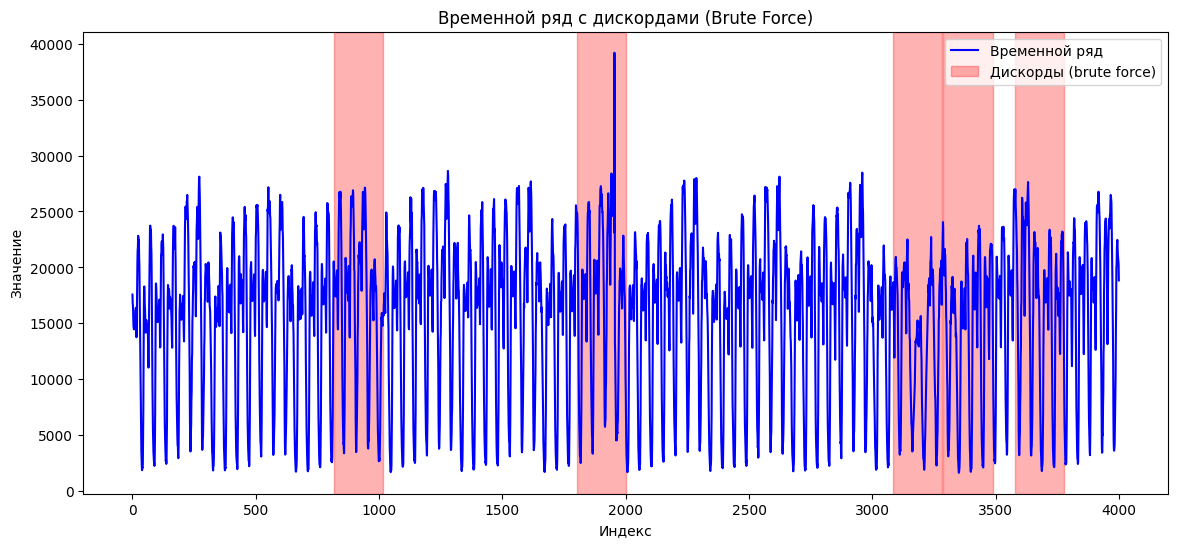

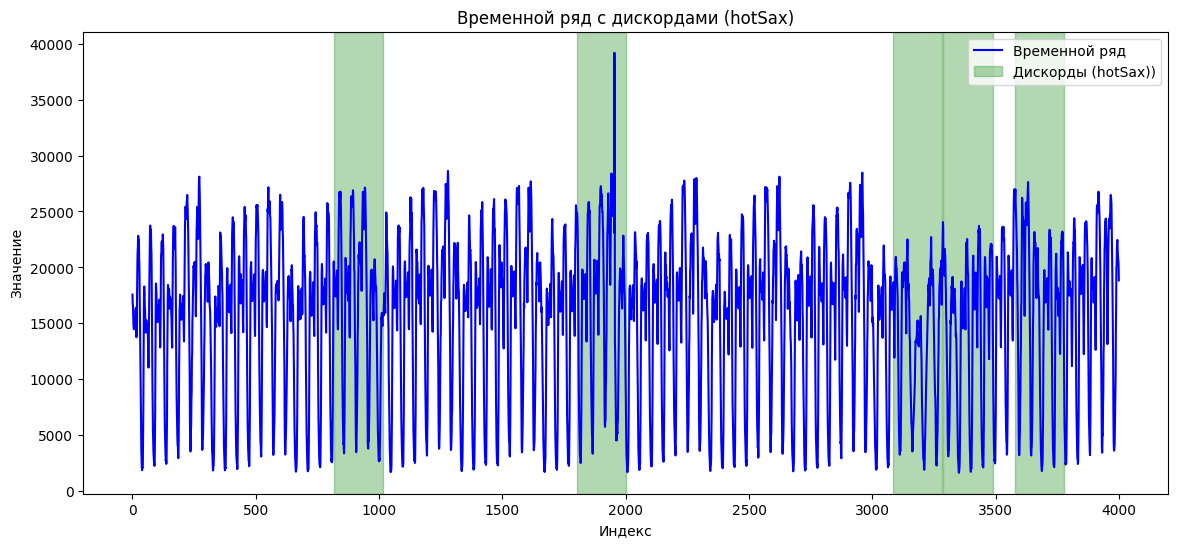

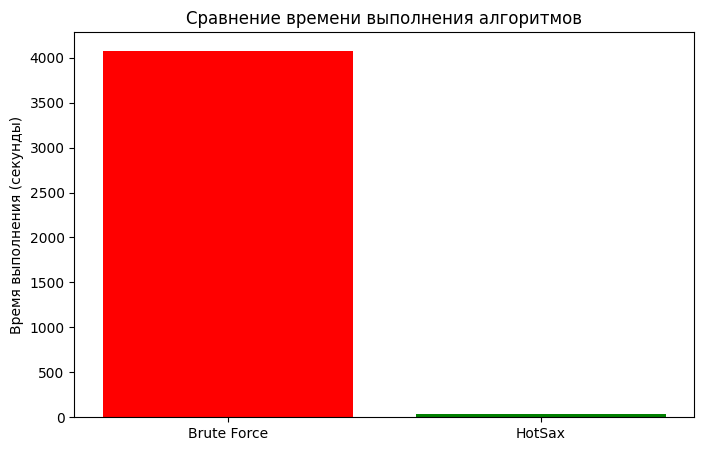

In [ ]:
from matplotlib.patches import Rectangle

win_size = 200
plt.figure(figsize=(14, 6))

# График временного ряда
plt.plot(nyc_taxi, label='Временной ряд', color='blue')


for discord in result['bruteForce_taxi']:
    start_idx = int(discord[0])
    plt.axvspan(start_idx, start_idx + win_size, color='red', alpha=0.3, label='Дискорды (brute force)')

# Удаление дубликатов меток
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.title("Временной ряд с дискордами (Brute Force)")
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.show()

# 4. Вторая фигура: Временной ряд с дискордами (hotSax)
plt.figure(figsize=(14, 6))
plt.plot(nyc_taxi, label='Временной ряд', color='blue')

for discord in result['hotSax_taxi']:
    start_idx = int(discord[0])
    plt.axvspan(start_idx, start_idx + win_size, color='green', alpha=0.3, label='Дискорды (hotSax))')

# Удаление дубликатов меток
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.title("Временной ряд с дискордами (hotSax)")
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.show()

# 4. Столбчатая диаграмма времени работы
plt.figure(figsize=(8, 5))
algorithms = ['Brute Force', 'HotSax']
times_ = [times['bruteForce_taxi'], times['hotSax_taxi']]

plt.bar(algorithms, times_, color=['red', 'green'])
plt.ylabel("Время выполнения (секунды)")
plt.title("Сравнение времени выполнения алгоритмов")
plt.show()

#### **3.2 Поиск диссонансов с помощью алгоритма DRAG**

In [9]:
!pip install stumpy==1.11.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 5.8 MB/s eta 0:00:00


In [10]:
import stumpy
from stumpy import core, config
from stumpy.scrump import _prescrump


Как мы помним из лекций:

**Диапазонный диссонанс** – подпоследовательность ряда, расстояние от которой до ее ближайшего соседа не ниже заданного порога.

Основными параметрами при поисках диссонансов являются:
- $m$ - длина диссонанса
- $r$ - пороговое значение расстояния подпоследовательности ряда, до его ближайшего соседа


In [11]:
from modules.drag import find_candidates, DRAG


Для поиска диссонансов в данной части практической работы мы воспользуемся алгоритмом **DRAG (Discord Range Aware Gathering)**.
Для начала воспользуемся данным алгоритмом, чтобы найти диссонансы в наборе данных содержащем активность человека.

In [ ]:
data = walk_run

Длину искомого диссонанса, как и для предыдущих алгоритмов, мы установим равно 50 точек.
Пороговое значение мы установим равным большим, чтобы узнать, как алгоритм отреагирует на большие значения данного параметра.

In [ ]:
m = 50
r = 10
idxs, _, _ = DRAG(data,m,r)
print(f'Колличество найденных диссонансов: {len(idxs)}')

Колличество найденных диссонансов: 0


Как вы можете видеть мы установили слишком большое пороговое значение, алгоритму не удалось выделить ни одного диссонанса. Попробуем уменьшить пороговое значение до 1, чтобы улучшить результат.

In [ ]:
m = 50
r = 1
idxs, _, _ = DRAG(data, m, r)
print(f'Колличество найденных диссонансов: {len(idxs)}')

Колличество найденных диссонансов: 50


При такой комбинации параметров, улучшить ситуацию не получилось. Алгоритм выделил слишком большое количество диссонансов, часть которых является ложными диссонансами и не будут информативными для нас.

Произведите подобные эксперименты с набором данных такси NY. Постройте графики демонстрирующие найденные диссонансы. Пример Графика:
![second-graph](pics/fig_ex_2.png)

In [ ]:
# INSERT YOUR CODE
m = 50
r = 10
idxs, _, _ = DRAG(nyc_taxi,m,r)
print(f'Колличество найденных диссонансов: {len(idxs)}')

Колличество найденных диссонансов: 0


Колличество найденных диссонансов: 42
[1910, 1952, 3120, 1934, 3142, 3183, 3156, 3237, 3197, 3280, 3251, 3102, 963, 3915, 1892, 992, 1865, 3087, 977, 3295, 3579, 1006, 3220, 541, 3266, 946, 3565, 3939, 3604, 3794, 556, 3852, 188, 576, 32, 3315, 3838, 143, 3055, 3070, 46, 3810]


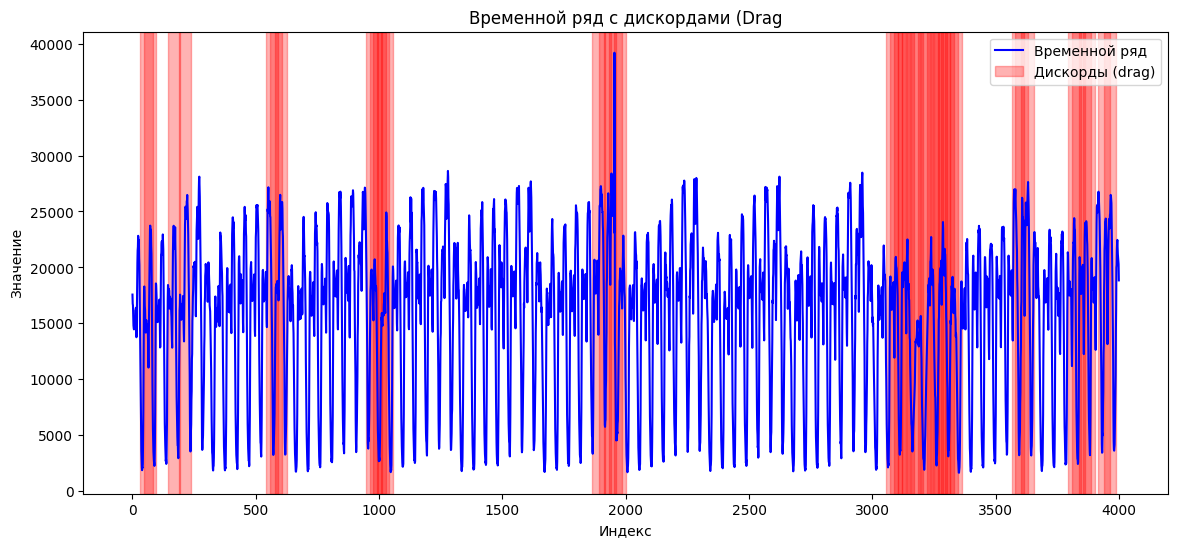

In [ ]:
# INSERT YOUR CODE
m = 50
r = 1
idxs, _, _ = DRAG(nyc_taxi,m,r)

# График временного ряда
win_size = 50
plt.figure(figsize=(14, 6))
plt.plot(nyc_taxi, label='Временной ряд', color='blue')

print(idxs)
for discord in idxs:
    start_idx = int(discord)
    plt.axvspan(start_idx, start_idx + win_size, color='red', alpha=0.3, label='Дискорды (drag)')

# Удаление дубликатов меток
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.title("Временной ряд с дискордами (Drag")
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.show()

Чтобы разобраться, почему так происходит и как работает данный алгоритм, ниже мы реализуем все этапы алгоритма DRAG.

Как мы помним из лекций алгоритм DRAG содержит два этапа:

1. Отбор - За одно сканирование ряда сформировать множество кандидатов в диссонансы.
2. Очистка - За одно сканирование ряда отбросить кандидатов, которые являются ложными диссонансами.

##### 3.2.1 Отбор кандидатов

Первым этапом обработки данных является отбор множества потенциальных кандидатов. Мы выбираем из всего множества подпоследовательностей ряда такие, для которых расстояние до правых ближайших соседей больше параметра $r$.

In [ ]:
#выбирем более реальное значение для порога
r = 3

In [ ]:
T, M_T, Σ_T = core.preprocess(data, m)
#формируем массив длинной равной длине  исходного ряда - m + 1,
#элемент массива является истинным,
#в том случае если подпоследовательность является потенциальным кандидатом
is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=None, right=True)
#находим индексы потенциальных кандидатов
cand_index = np.flatnonzero(is_cands)

In [ ]:
print(f'{len(cand_index)} {len(cand_index)/len(data)*100} %')

113 11.3 %


Во время отбора кандидатов нам удалось выделить около 113 подпоследовательностей(около 11.3%), которые мы бы могли назвать потенциальными диссонансами.
Это большой процент, который не может нас устраивать как конечный результат.
Если посмотреть на рисунок ниже, мы увидим, что большая часть потенциальных диссонансов расположена в районе смены активности.
К сожалению пресутсвуют и ложные диссонансы, которые случайным образом попали в данный список.

Сформируйте график найденных диссонансов

[1910, 1952, 3120, 1934, 3142, 3183, 3156, 3237, 3197, 3280, 3251, 3102, 963, 3915, 1892, 992, 1865, 3087, 977, 3295, 3579, 1006, 3220, 541, 3266, 946, 3565, 3939, 3604, 3794, 556, 3852, 188, 576, 32, 3315, 3838, 143, 3055, 3070, 46, 3810]


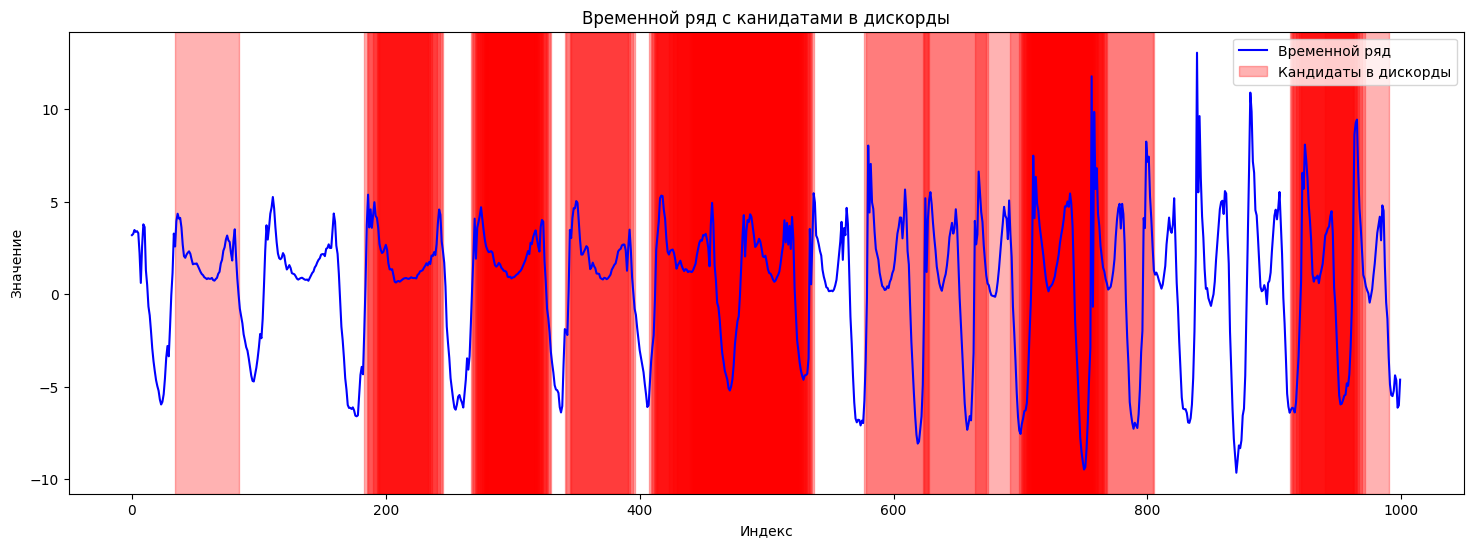

In [ ]:
# INSERT YOUR CODE
# График временного ряда
win_size = m
plt.figure(figsize=(18, 6))
plt.plot(data, label='Временной ряд', color='blue')

print(idxs)
for discord in cand_index:
    start_idx = int(discord)
    plt.axvspan(start_idx, start_idx + win_size, color='red', alpha=0.3, label='Кандидаты в дискорды')

# Удаление дубликатов меток
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.title("Временной ряд с канидатами в дискорды")
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.show()

##### 3.2.2 Очистка кандидатов
Как уже упоминалось выше, 11.3% слишком большой процент диссонансов.
Для уменьшения числа потенциальных кандидатов произведем очистку от ложных диссонансов, путем сравнения расстояния до левых ближайших соседей потенциальных диссонансов с порогом $r$.


In [ ]:
is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=is_cands, right=False)
cands = np.flatnonzero(is_cands)

In [ ]:
len(cands)/len(data)*100

2.9000000000000004

Сформируйте график найденных диссонансов

[1910, 1952, 3120, 1934, 3142, 3183, 3156, 3237, 3197, 3280, 3251, 3102, 963, 3915, 1892, 992, 1865, 3087, 977, 3295, 3579, 1006, 3220, 541, 3266, 946, 3565, 3939, 3604, 3794, 556, 3852, 188, 576, 32, 3315, 3838, 143, 3055, 3070, 46, 3810]


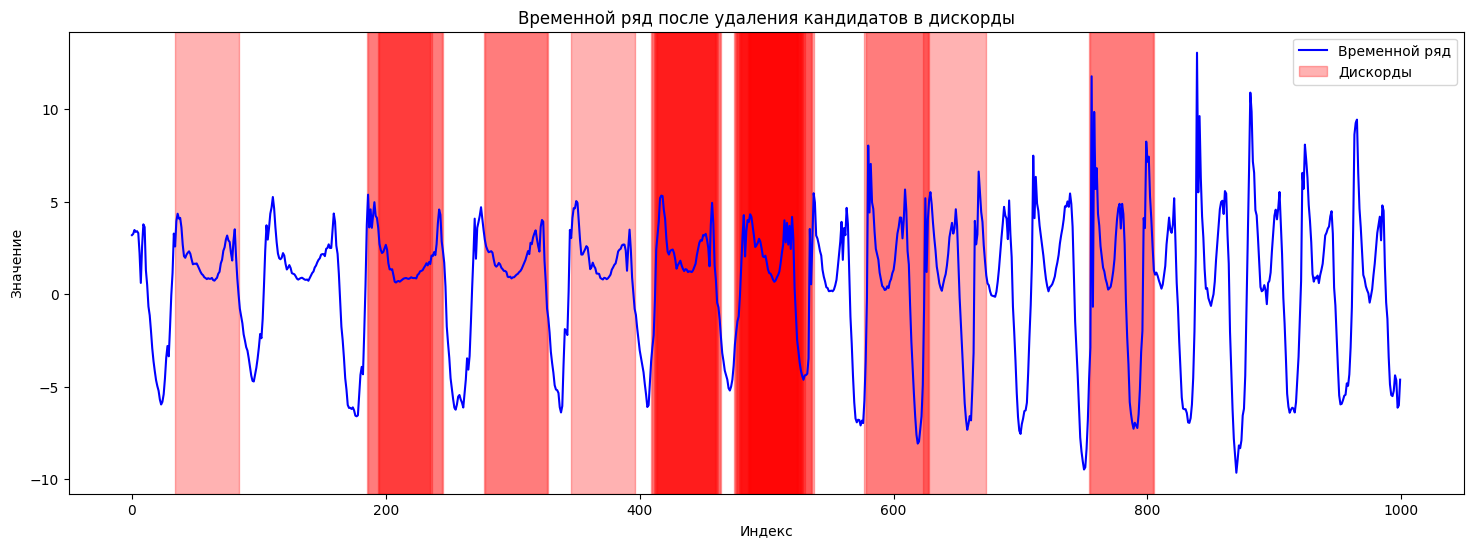

In [ ]:
# INSERT YOUR CODE
win_size = m
plt.figure(figsize=(18, 6))
plt.plot(data, label='Временной ряд', color='blue')

for discord in cands:
    start_idx = int(discord)
    plt.axvspan(start_idx, start_idx + win_size, color='red', alpha=0.3, label='Дискорды')

# Удаление дубликатов меток
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.title("Временной ряд после удаления кандидатов в дискорды")
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.show()

Нам удалось сократить число диссонансов до 2.9%. Если проанализировать рисунок, то можно заметить, что большая их часть является тривиальными повторениями подпоследовательности в области смены активности. На следующем шаге избавимся от них.

In [ ]:
from modules.drag import refine_candidates
discords_idx, discords_dist, discords_nn_idx = refine_candidates(T, m, M_T, Σ_T, is_cands)
len(discords_idx)/len(data)*100

9


0.8999999999999999

Сформируйте график найденных диссонансов

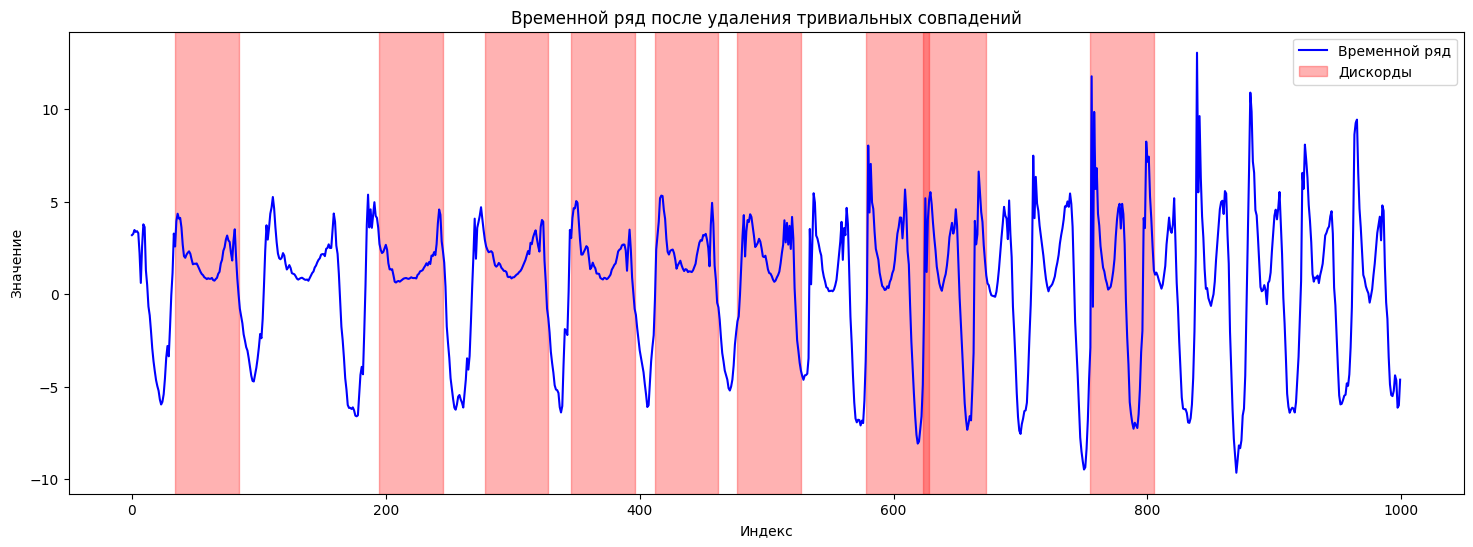

In [ ]:
# INSERT YOUR CODE
win_size = m
plt.figure(figsize=(18, 6))
plt.plot(data, label='Временной ряд', color='blue')

for discord in discords_idx:
    start_idx = int(discord)
    plt.axvspan(start_idx, start_idx + win_size, color='red', alpha=0.3, label='Дискорды')

# Удаление дубликатов меток
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.title("Временной ряд после удаления тривиальных совпадений")
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.show()

##### 3.2.3 Подбор параметров

Реализуйте перебор параметров $m$ и $r$. Подберете параметры таким образом, чтобы алгоритм обнаружил только те диссонансы, которые связаны со сменой активности. Сделайте вывод о том, как эти параметры влияют на качество работы модели.
Подберите оптимальные параметры алгоритма для набора данных такси NY.
Визуализируйте результаты для разных комбинаций. Сделайте выводы.


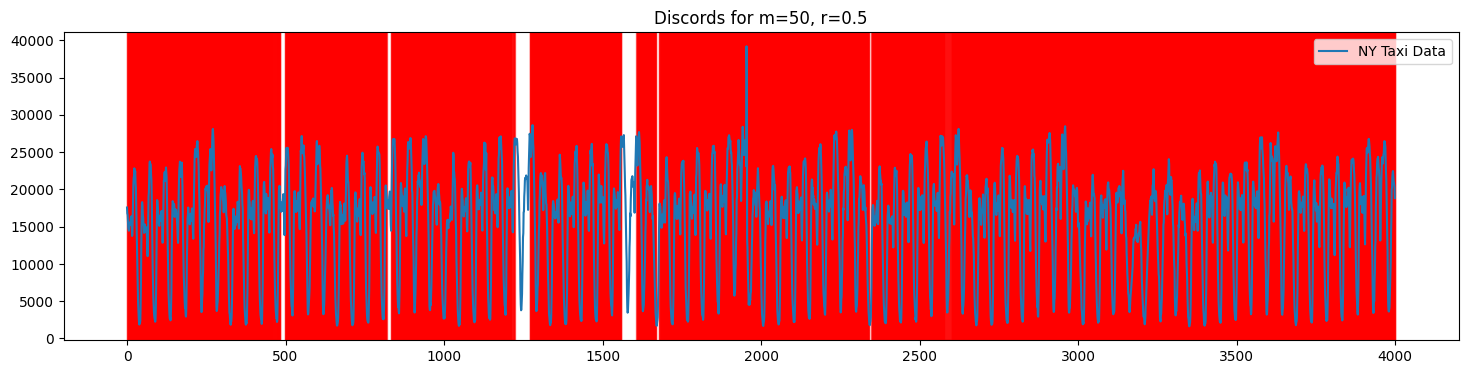

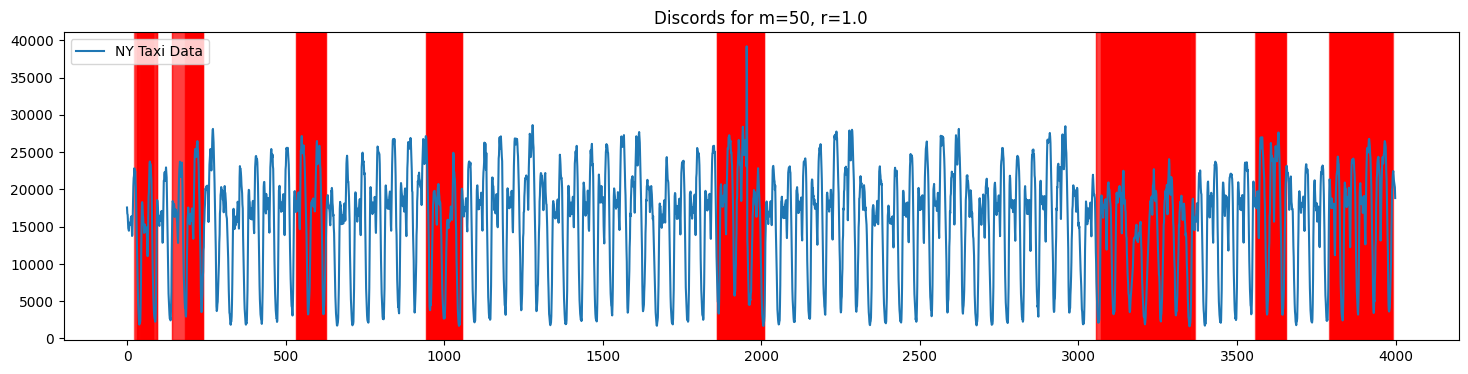

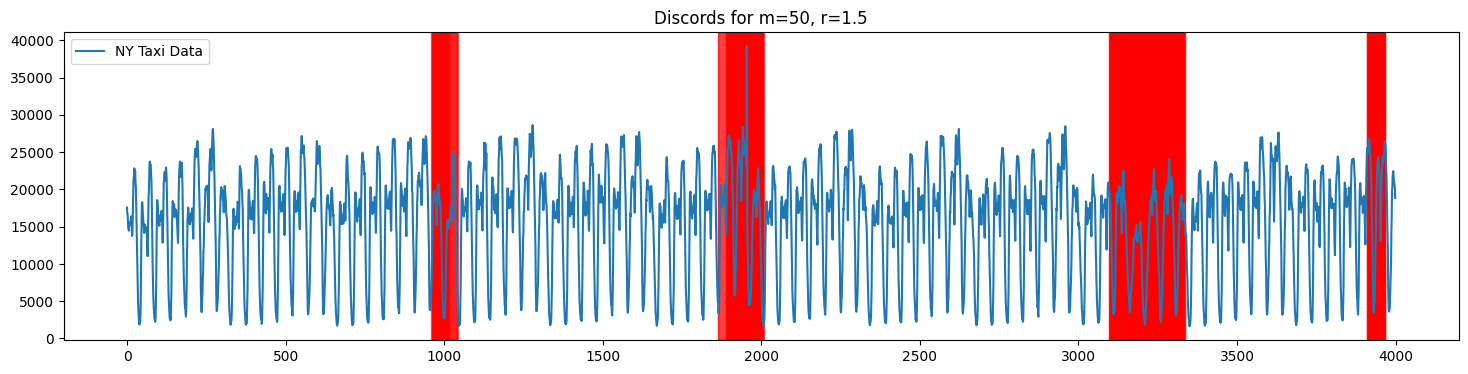

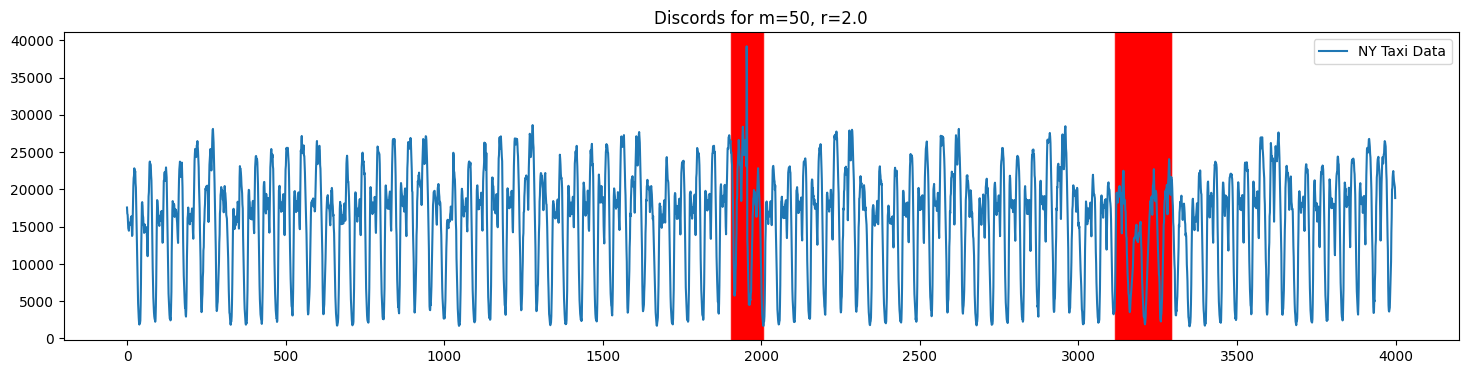

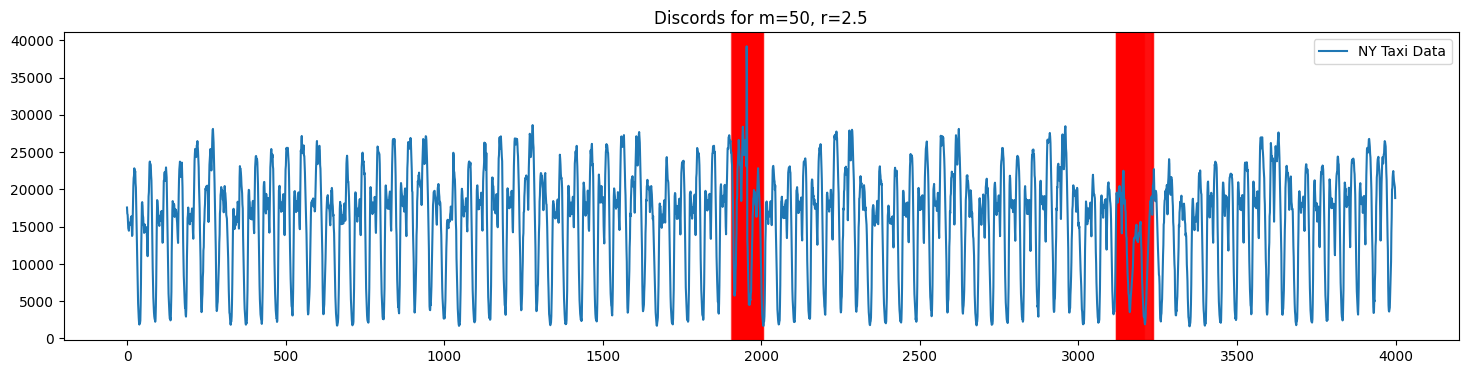

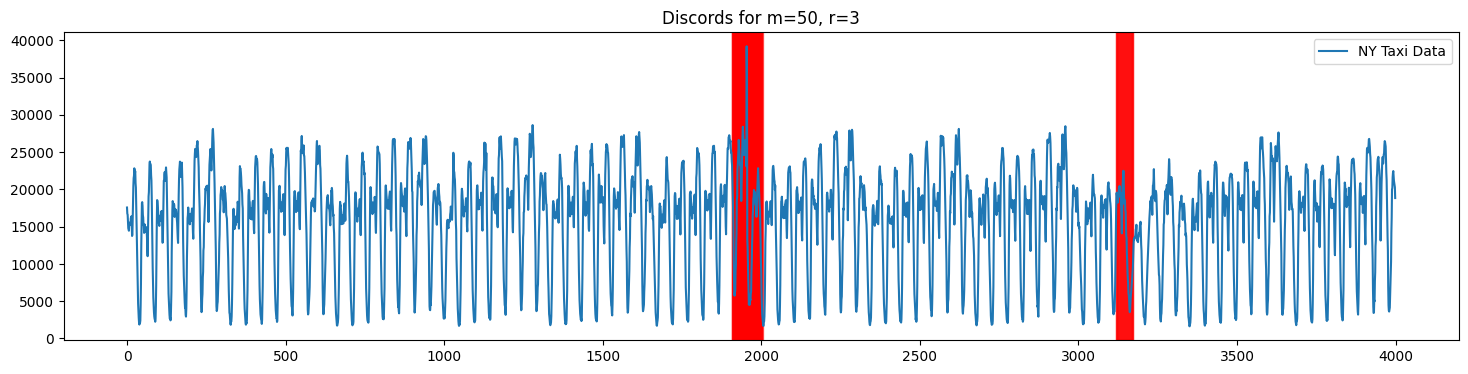

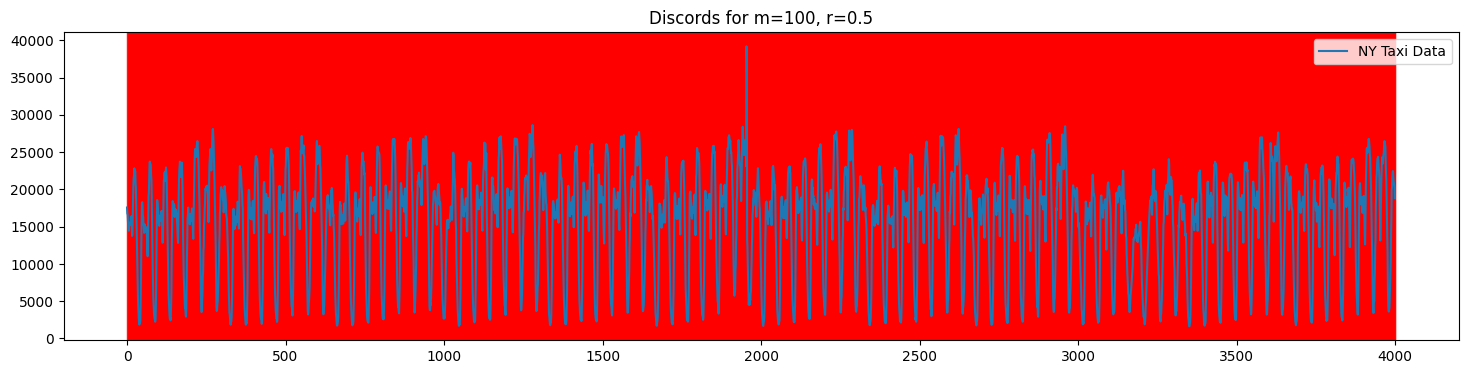

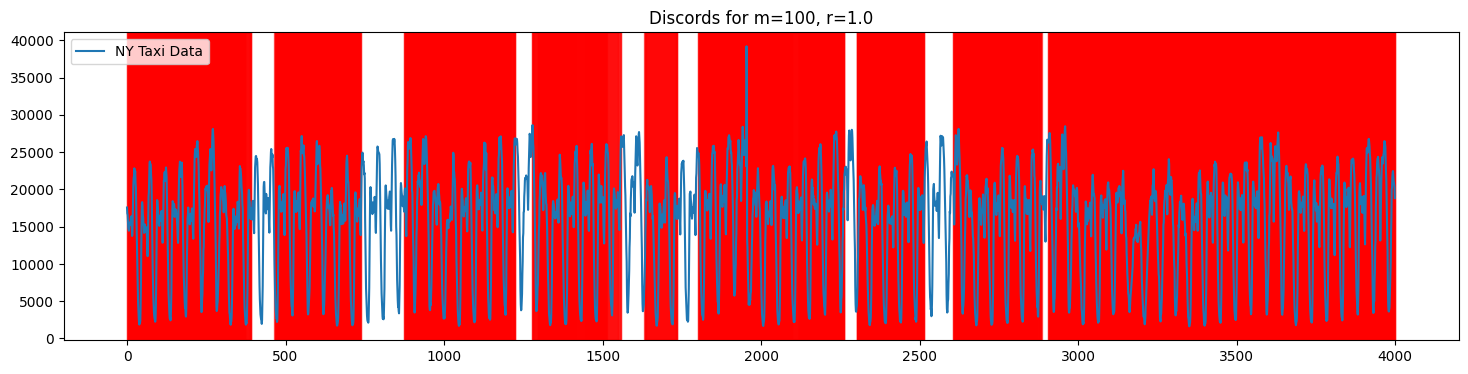

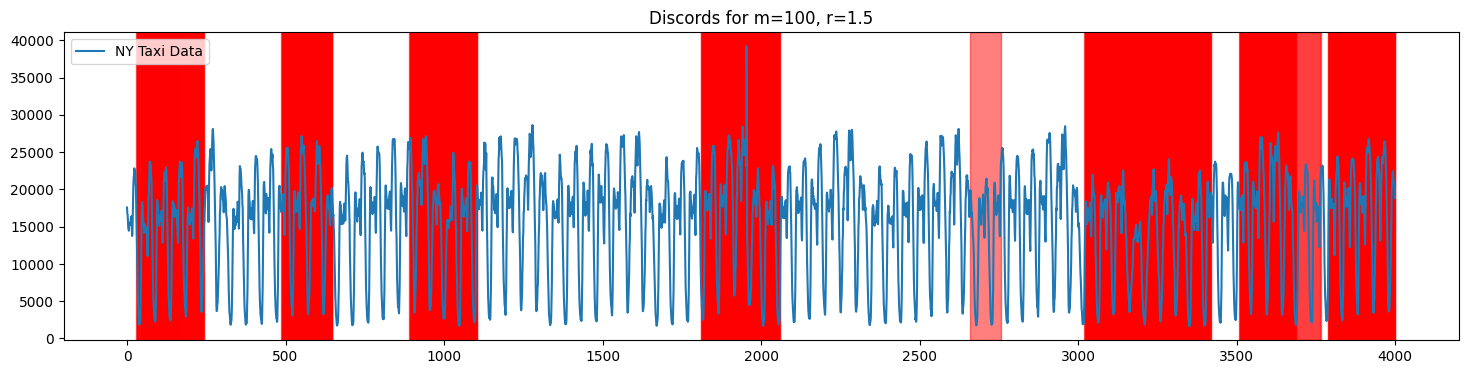

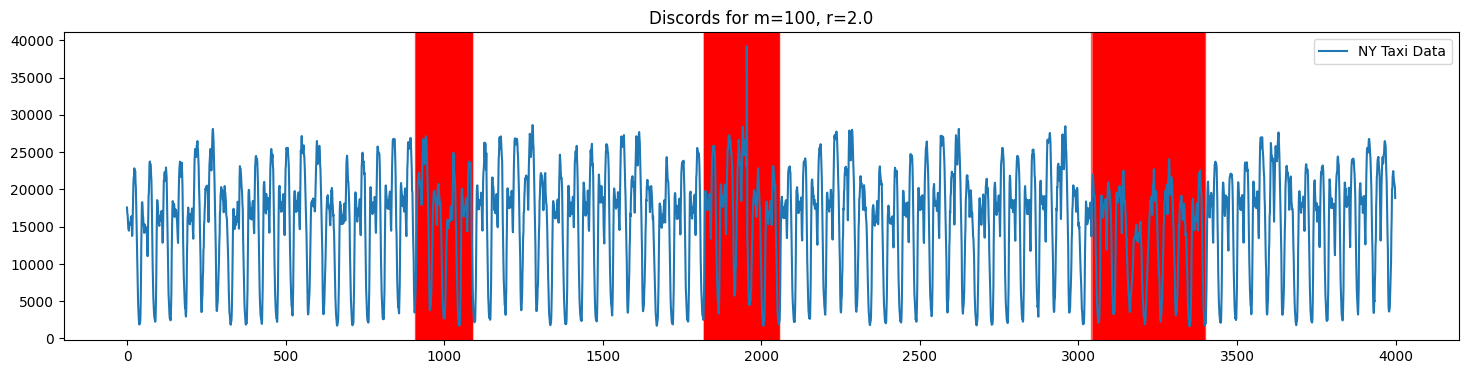

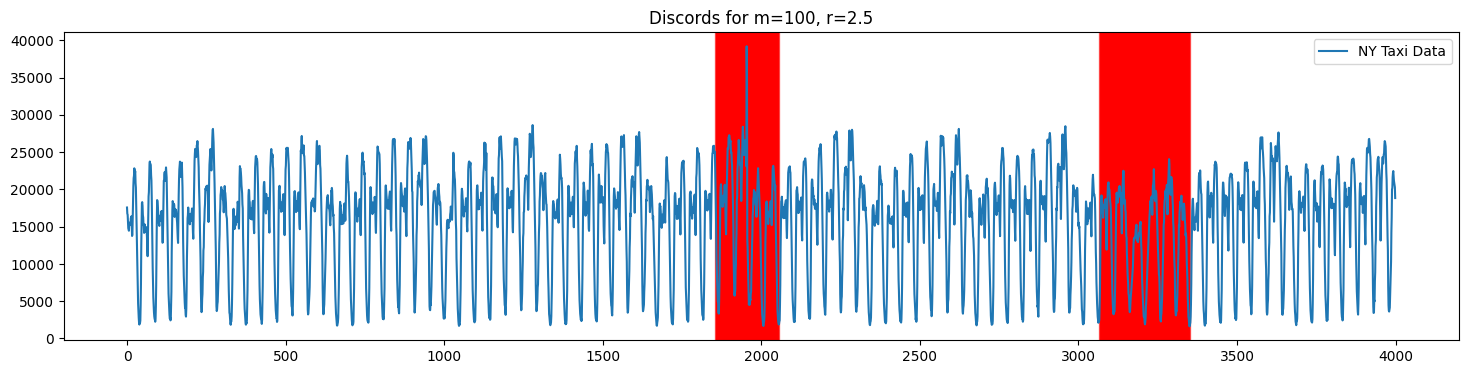

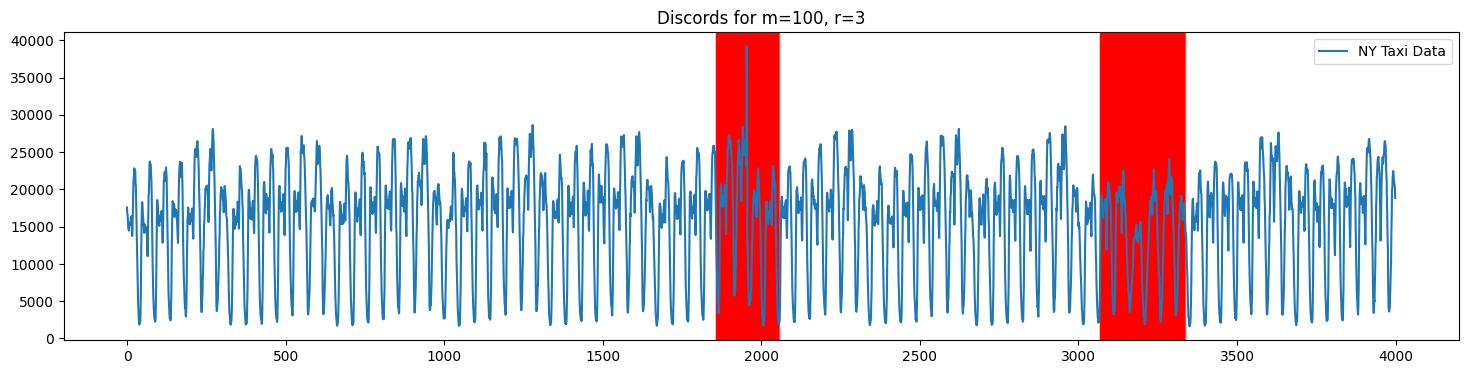

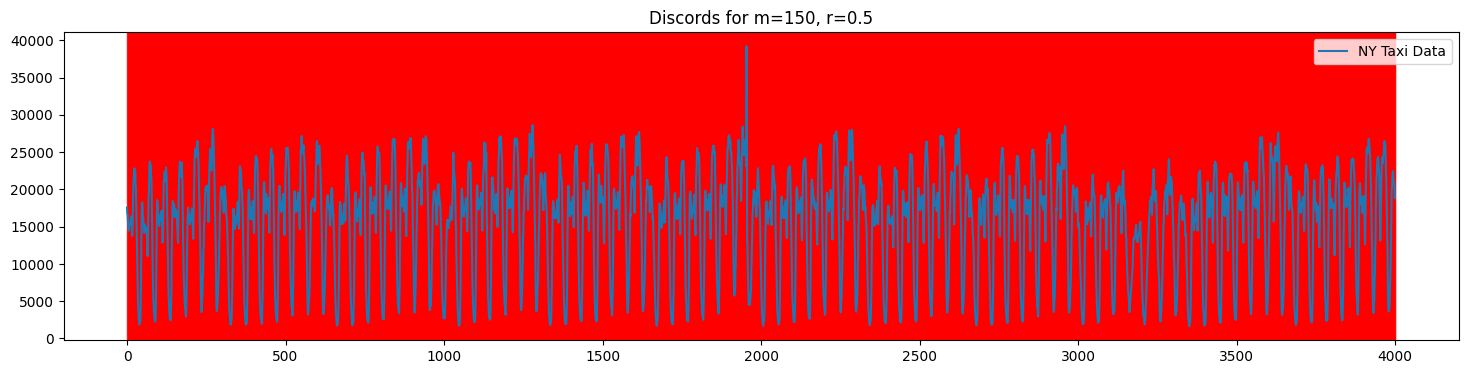

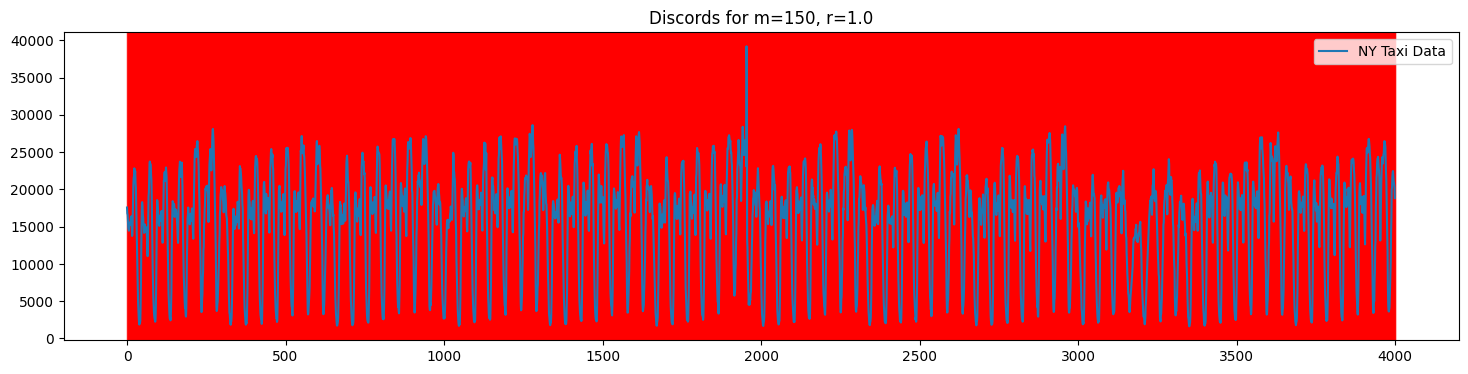

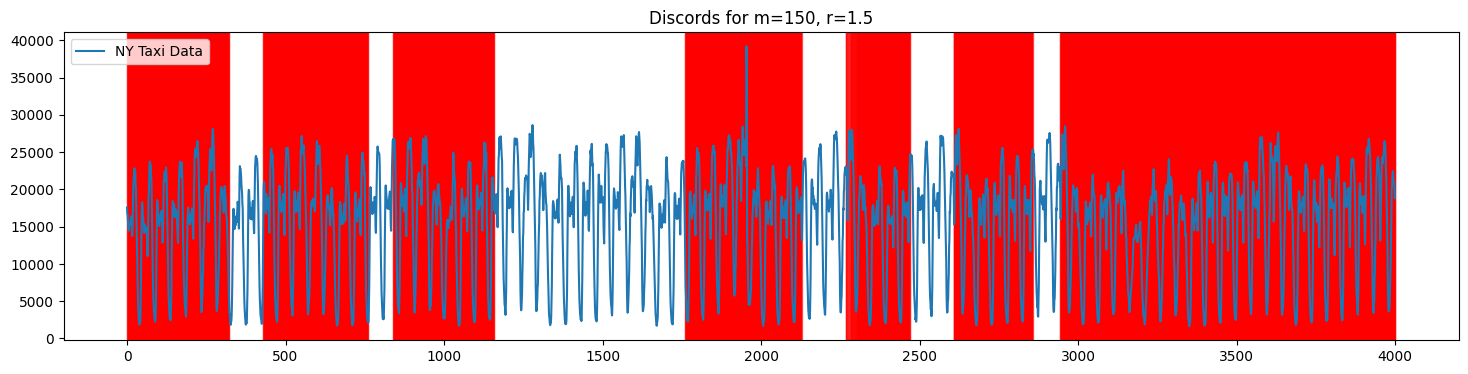

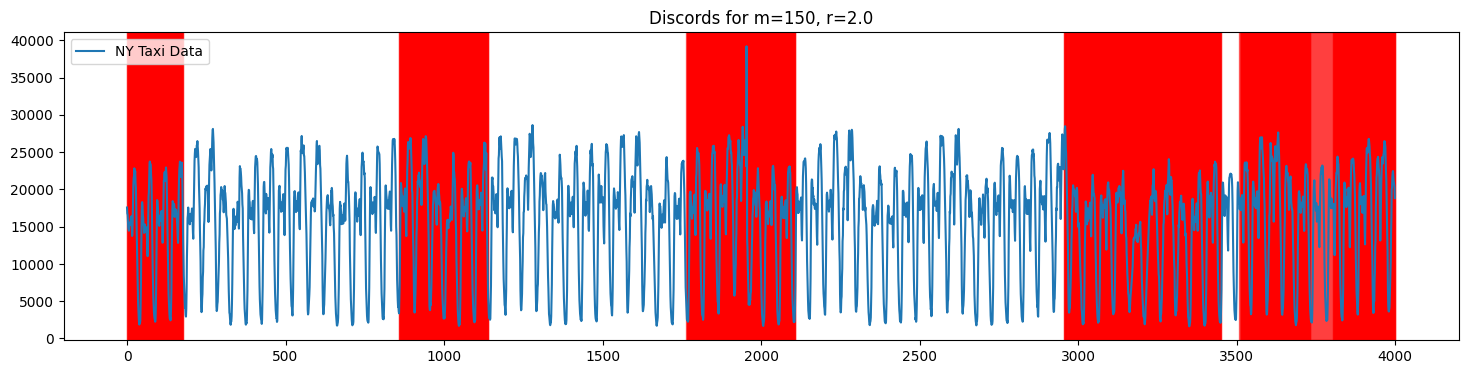

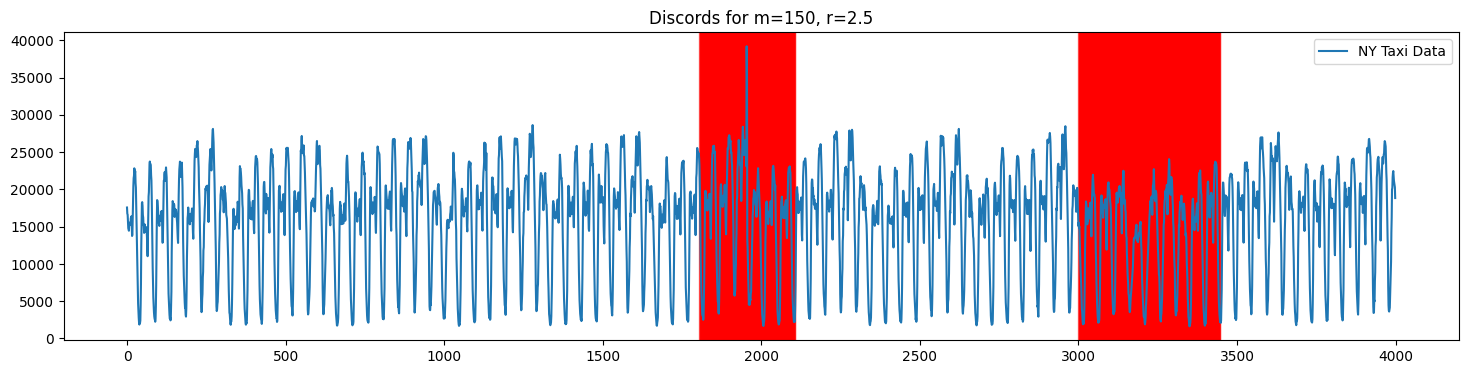

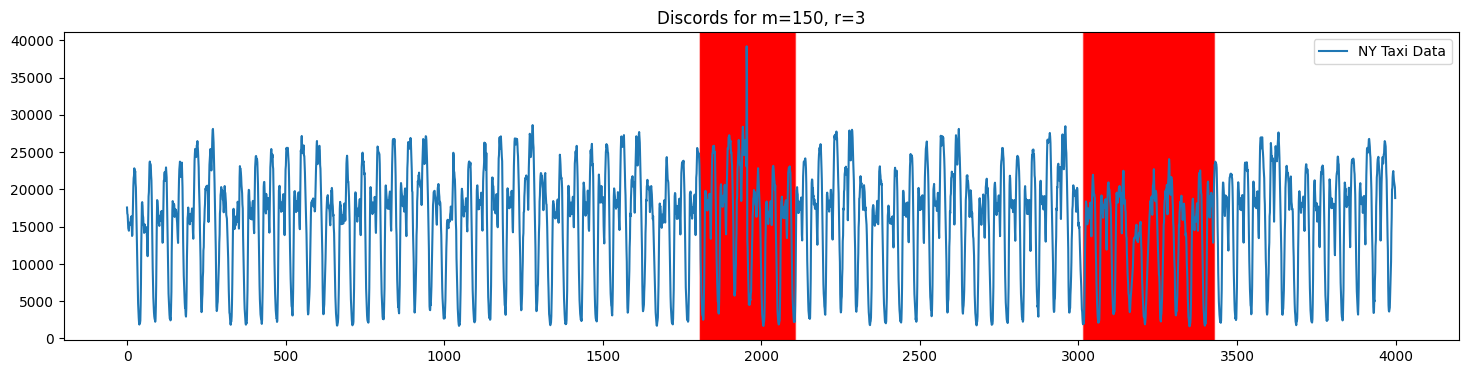

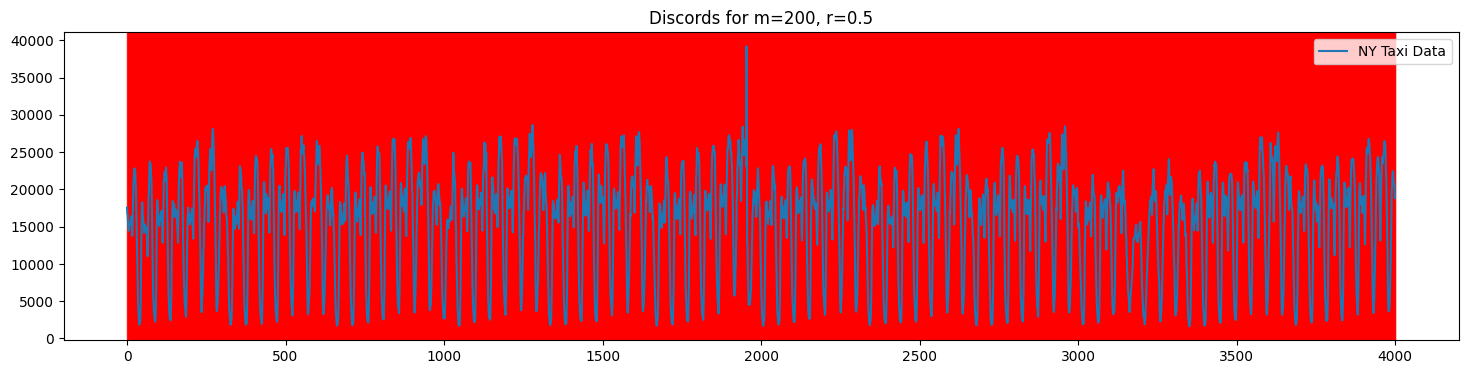

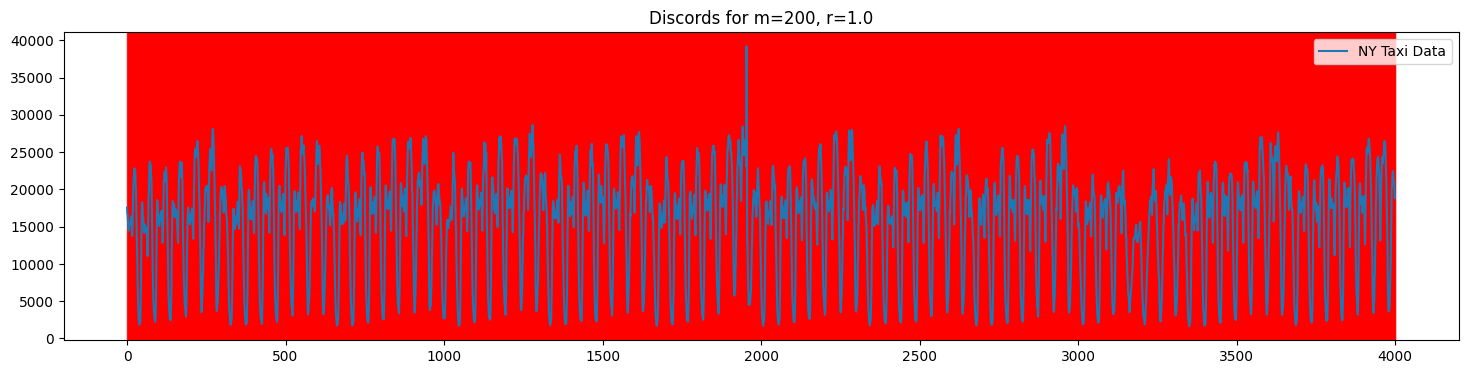

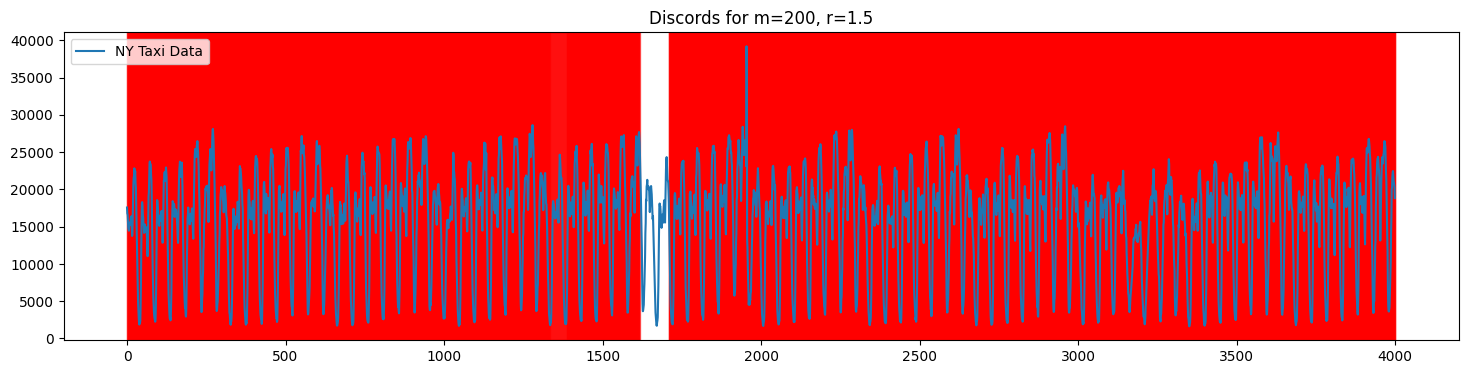

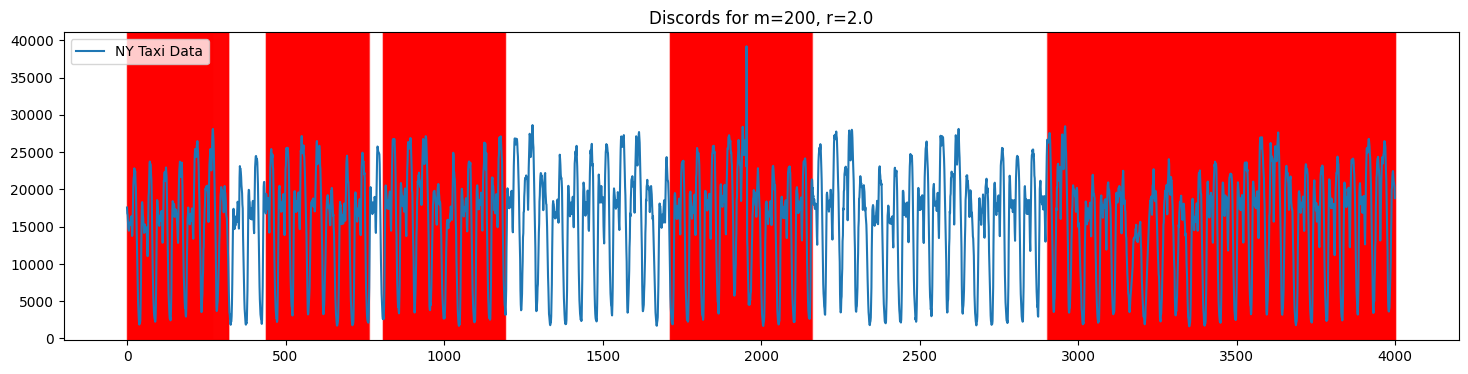

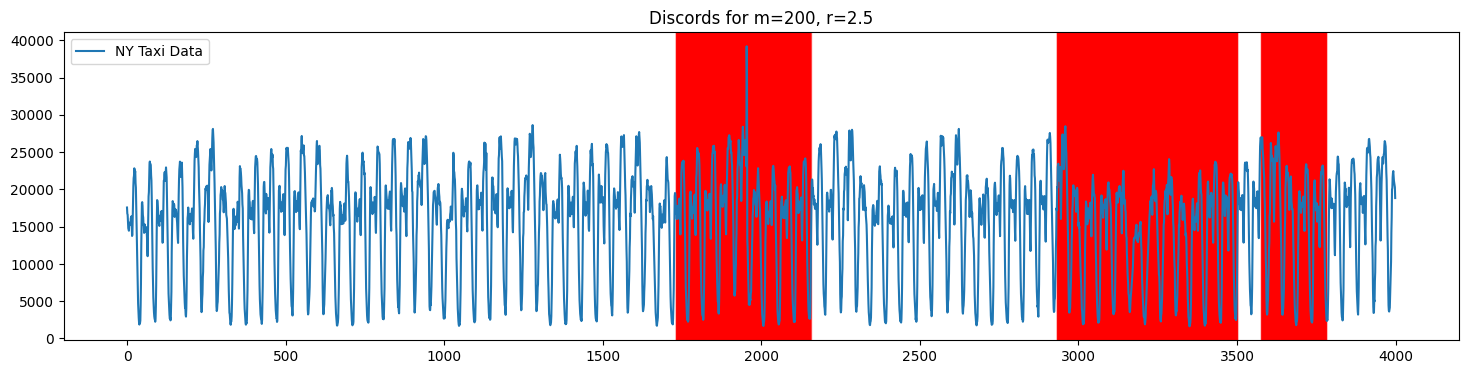

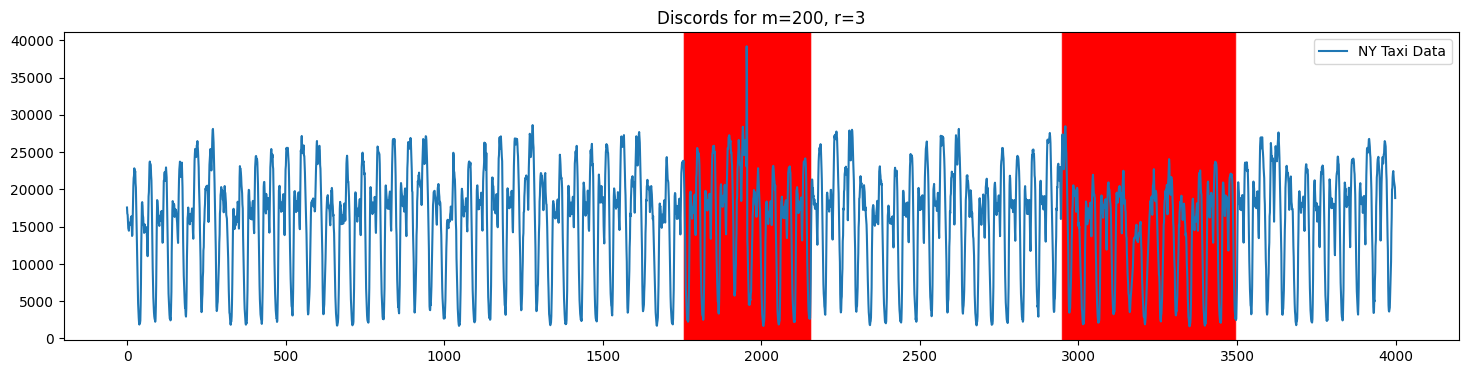

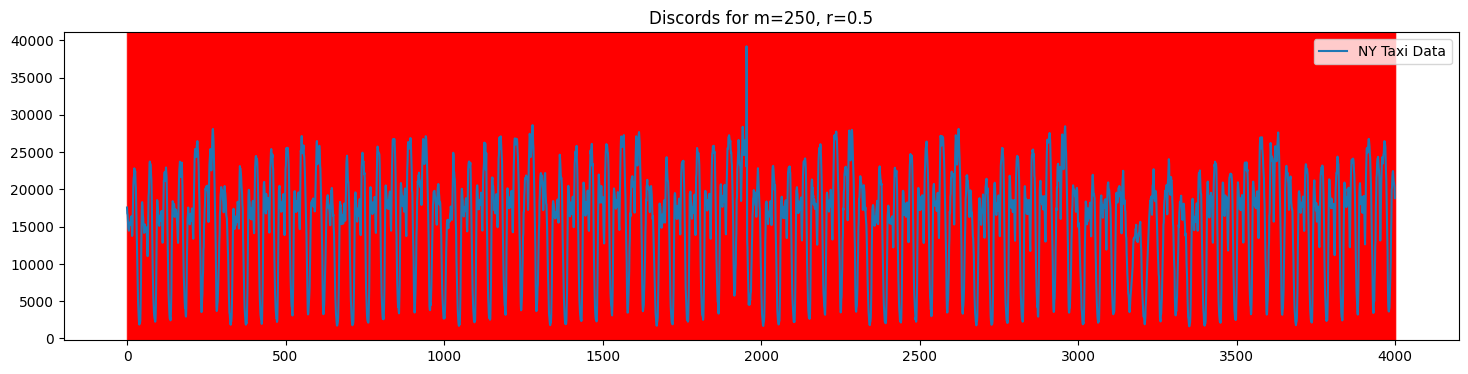

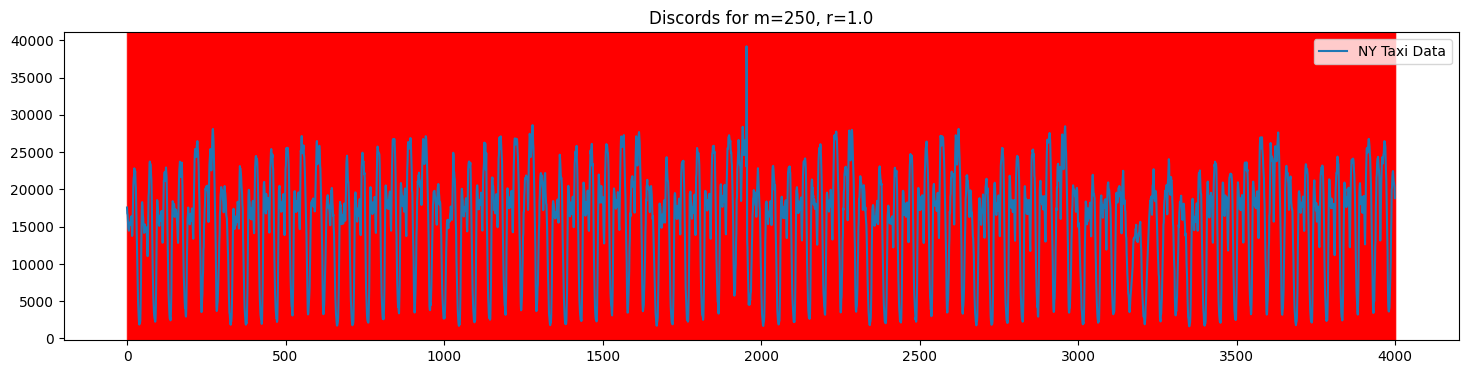

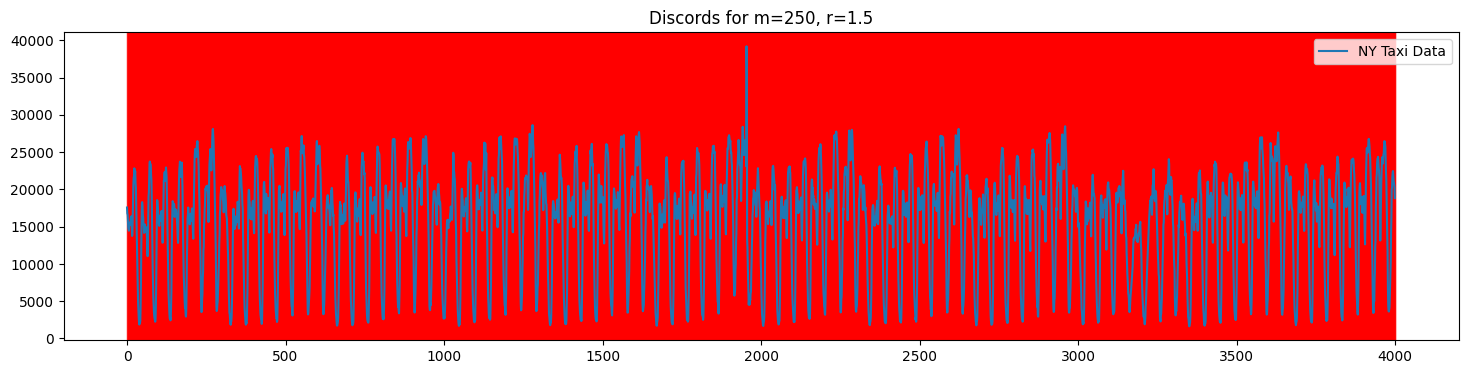

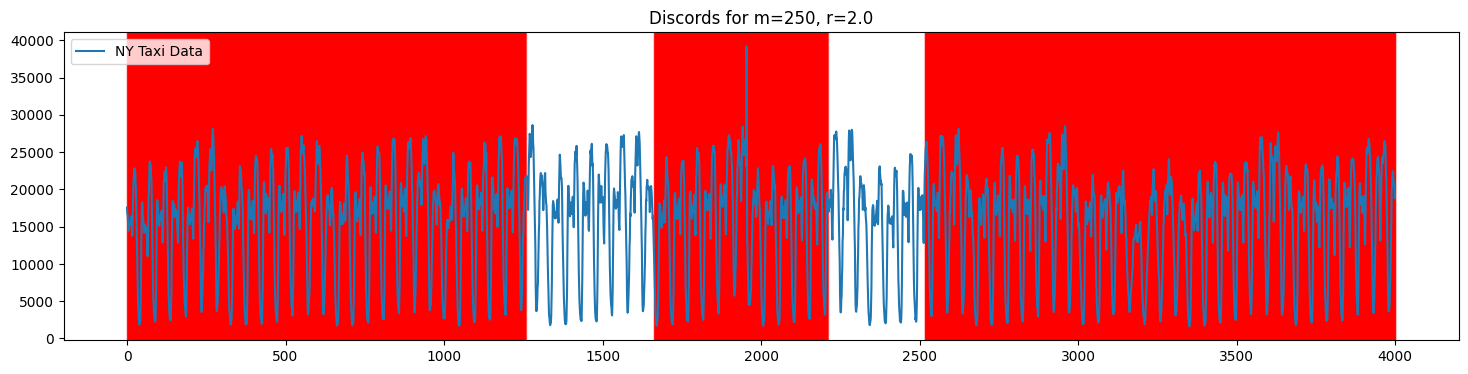

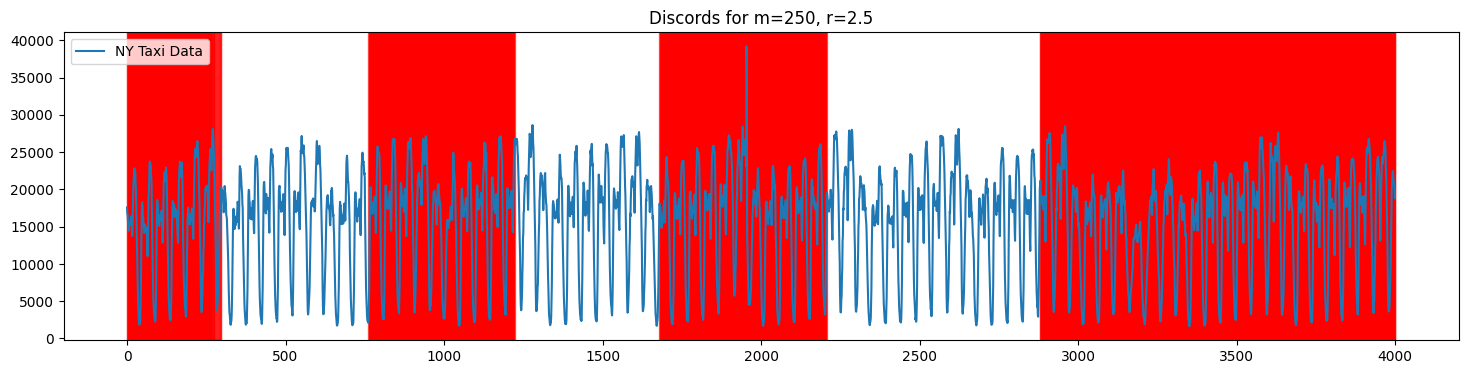

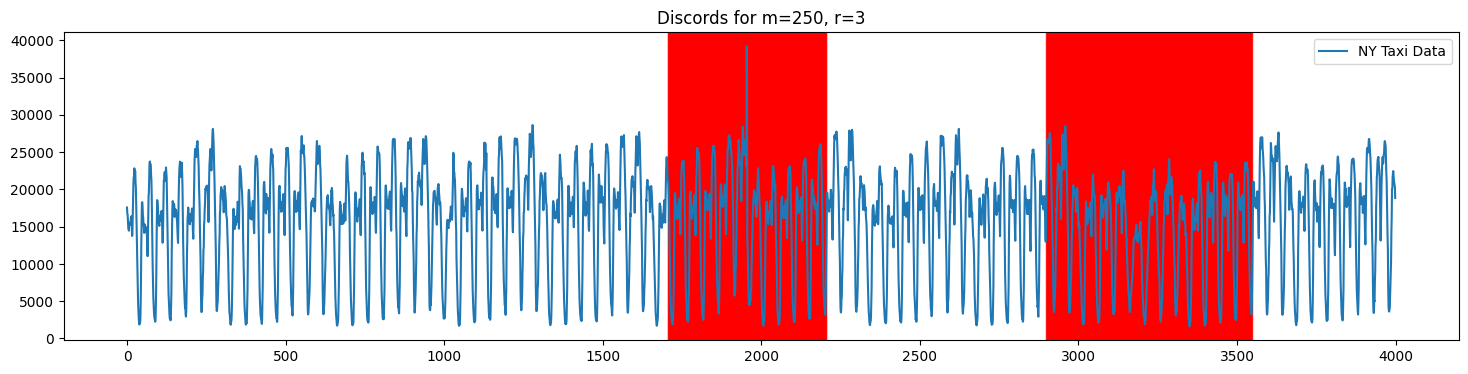

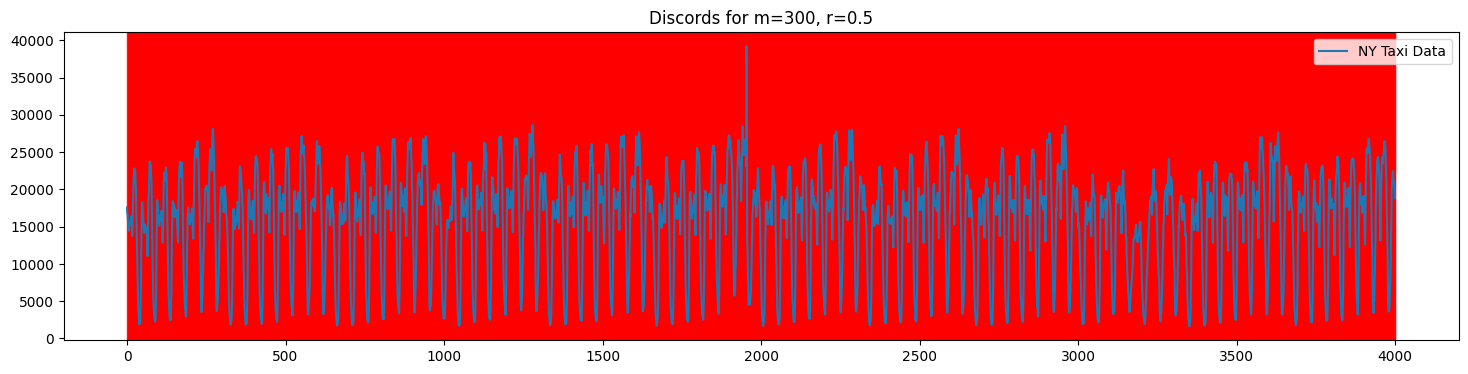

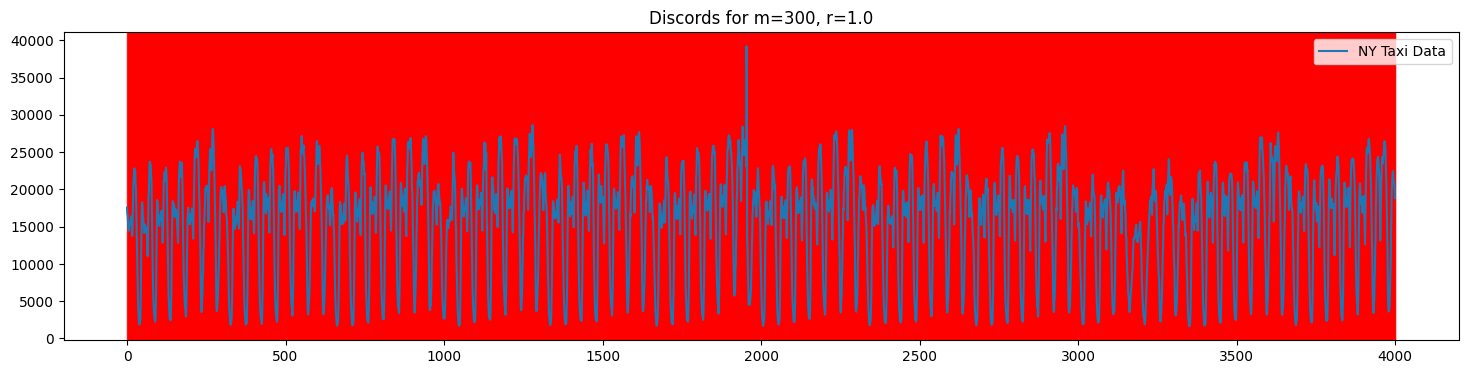

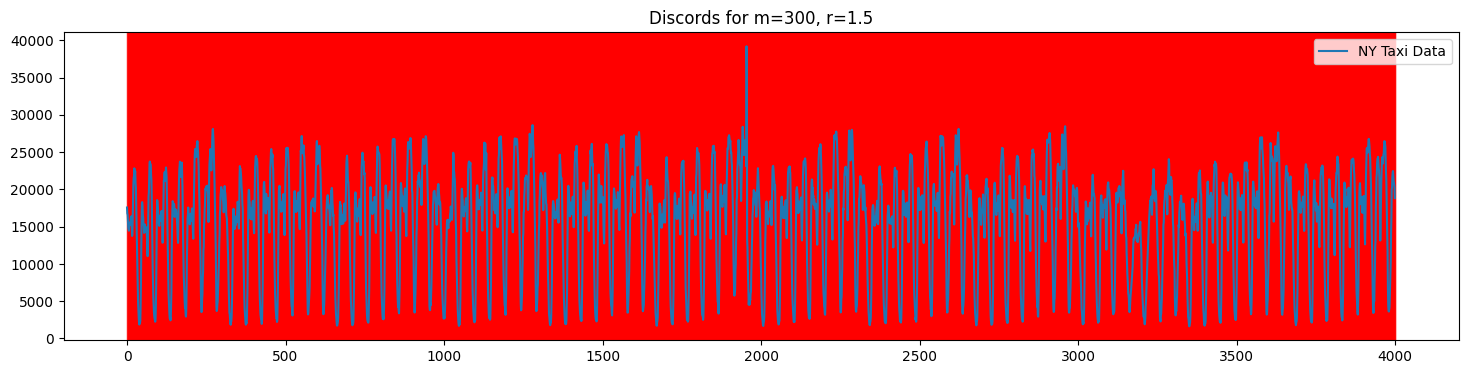

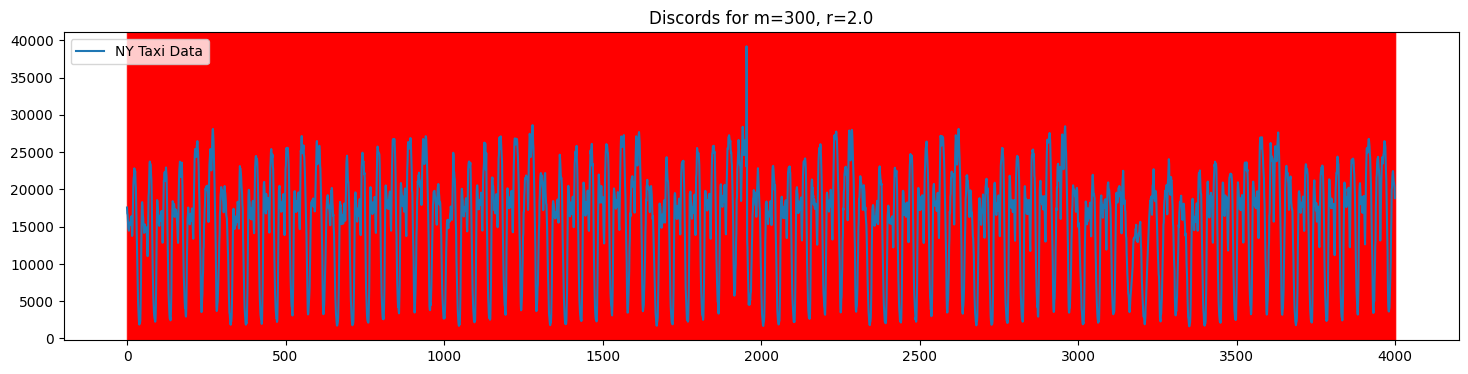

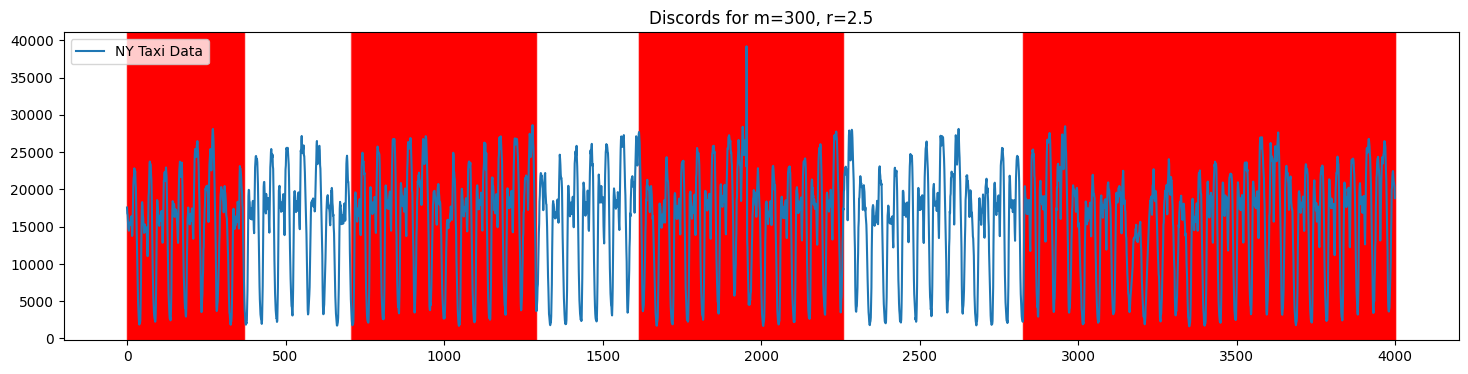

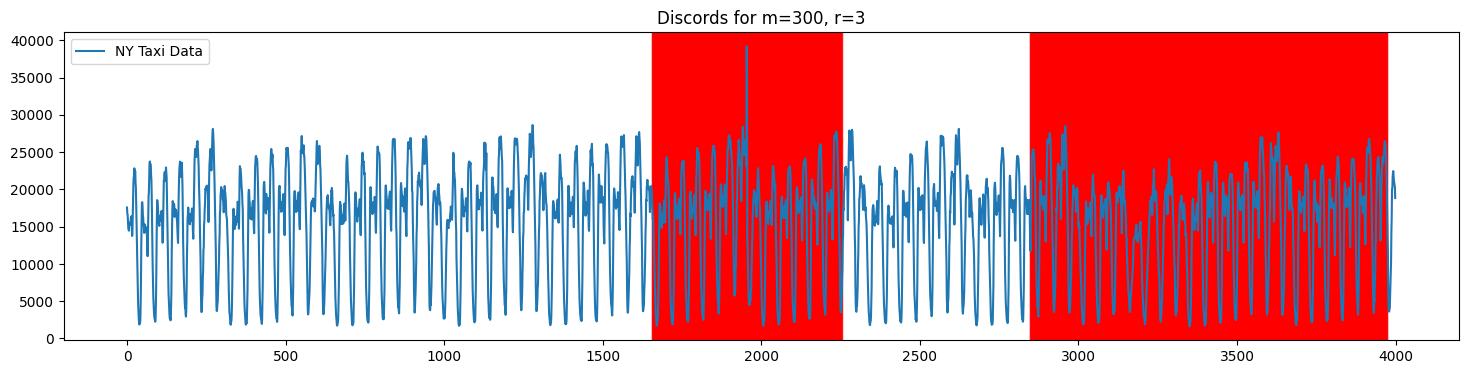

In [17]:
# INSERT YOUR CODE

m_values = [50, 100, 150, 200, 250, 300]
r_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3]

results = {}

# Перебор параметров
for m in m_values:
    for r in r_values:
        T, M_T, Σ_T = core.preprocess(nyc_taxi, m)
        #формируем массив длинной равной длине  исходного ряда - m + 1,
        #элемент массива является истинным,
        #в том случае если подпоследовательность является потенциальным кандидатом
        is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=None, right=True)
        #находим индексы потенциальных кандидатов
        cand_index = np.flatnonzero(is_cands)
        is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=is_cands, right=False)
        cands = np.flatnonzero(is_cands)

        discords = cands
        results[(m, r)] = discords

        # Визуализация результатов
        fig = plt.figure(figsize=(18, 4))
        plt.plot(nyc_taxi, label='NY Taxi Data')
        for discord in discords:
            start = discord
            plt.axvspan(start, start + m, color='red', alpha=0.5)
        plt.title(f'Discords for m={m}, r={r}')
        plt.legend()
        plt.show()

#### **3.3 Поиск диссонансов с помощью алгоритма Merlin**

Как мы уже выяснили подбирать параметры для DRAG простым перебором не очень удобно. Для оптимизации данного процесса в статье [1] был предложен алгоритм Merlin для оптимального поиска подходящего порогового значения.

Условно мы можем разделить поиск диссонансов на три шага:

1. Поиск диссонансов минимальной длинны $minL$. На данном шаге $r = 2\sqrt{minL}$.
2. Поиск диссонансов следующих четырех длин. На данном шаге $r = 0.99 \cdot nndist_{m-1}$. Где $nndist_{m-1}$ - расстояние до ближайшего соседа предыдущего найденного диссонанса.
3. Поиск диссонансов всех
оставшихся дли. $r = \mu - 2 \sigma$. Средние значение и стандартное отклонение вычисляются из расстояний 5 предыдущих диссонансов. н

[1] Nakamura T., Imamura M., Mercer R., Keogh E.J. MERLIN: parameter-free discovery of arbitrary length anomalies in massive time series archives. 20th IEEE Int. Conf. on Data Mining, ICDM 2020, Sorrento, Italy, November 17-20, 2020. pp. 1190-1195. IEEE (2020). https://doi.org/10.1109/ICDM50108.2020.00147

##### 3.3.1 Поиск диссонансов минимальной длинны

Вспомнил последовательность действий первого шага алгоритма:
![merlin-part-first](pics/first_part.png)

В данной работе мы внесем небольшое изменение, мы будем считать, что подпоследовательность может быть диссонансом только в том случае, если больше 75% точек, не входят в состав других диссонансов.

In [ ]:
T = walk_run
m = 50
# сформируем массив метод для потенциальных кандидатов в диссонансы.
# после каждого найденного диссонанса,
# мы будем исключать окружающие его подпоследовательности из числа потенциальных кандидатов,
# путем замены значений их меток на false
excl_zone = int(np.ceil(m / 4))
include = np.ones(len(T)-m+1, dtype=bool)
# Количество диссонансов, которые мы будем искать
topK = 10


In [ ]:
dis_idx = -np.ones((topK))
dis_nnDist = -np.ones((topK))
dis_nn_idx = np.full((topK),-np.inf)
#первое прближение r
r = 2*np.sqrt(m)
minL = m
maxL = int(m+np.ceil(m*0.1))
#количество найденных диссонасов
cound_find_dis = 0

while dis_nnDist[cound_find_dis-1]<0 and cound_find_dis<topK:
    result = DRAG(data=T,m=minL,r=r, include =include)
    for diss, nnDist, nn in zip(*result):
        dis_idx[cound_find_dis] = diss
        dis_nnDist[cound_find_dis] = nnDist
        dis_nn_idx[cound_find_dis] = nn
        #исключаем окружающие найденный диссонас
        #подпоследовательности и числа потенциальных диссонасов
        core.apply_exclusion_zone(include, diss, excl_zone, False)
        cound_find_dis+=1
        if cound_find_dis>=topK:
            break
    r*=0.5

In [ ]:
maxL

55

In [ ]:
print('Количество найденных на первом этапе диссонансов:', cound_find_dis)

Количество найденных на первом этапе диссонансов: 2


На первом шаге нам удалось выделить 2 диссонанса из 10 требуемых.
Реализуйте, оставшиеся шаги алгоритма, чтобы найти оставшиеся диссонансы.

![merlin-part-first](pics/second_part.png)


In [ ]:
# INSERT YOUR CODE

Найдите диссонансы набора такси NY. Визуализируйте найденные диссонансы для обоих наборов данных, сравните с результатами остальных методов.


In [ ]:
# INSERT YOUR CODE